# SCM.293 - Assignment I: MDHFVRP in Manhattan
## Load Packages

In [205]:
import sys
import numpy as np
import math
import random

import pandas as pd

from scipy.spatial import distance
from haversine import haversine

import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt

from tqdm import tqdm

import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

## Define Classes

### Customer Nodes

In [206]:
class customer:
    """
    A class used to represent a single customer node
    
    Parameters
    ----------
    x : float
        the x-coordinate of the customer location
    y : float
        the y-coordinate of the customer location
    cust_ID : str
        a (preferrably unique) identifier of the customer
    q : float
        the amount of demand (i.e., drop size) of the customer
        default value: 1
    s : float
        the time required to serve the customer
        default value: 0

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the customer
    type : str
        an identifier of the type of node the class represents (here: customer node)
    closestNetworkNode : ID (int)
        node ID of closest road network node - required for OSM mapping and distances
        default: None
    
    """
    
    def __init__(self,
                x,             
                y,
                cust_ID,         
                q = 1,
                s = 0):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.cust_ID = str(cust_ID)
        self.type = 'customer'
        self.q = float(q)
        self.s = float(s)
        
        self.closestNetworkNode = None

### Depots

In [207]:
class depot:
    """
    A class used to represent a single depot node
    
    Parameters
    ----------
    x : float
        the x-coordinate of the customer location
    y : float
        the y-coordinate of the customer location
    color : str
        color with which to plot the routes departing from the depot when visualizing the results 
    dep_ID : str
        a (preferrably unique) identifier of the depot

    Other Attributes
    ----------
    loc : tuple
        the combined (x,y) location of the depot
    type : str
        an identifier of the type of node the class represents (here: depot node)
    s : float
        the time required to serve the depot
        needed for technical reasons
        set to zero
    q : float
        the amount of demand of the depot
        needed for technical reasons
        set to zero
    closestNetworkNode : ID (int)
        node ID of closest road network node - required for OSM mapping and distances
        default: None
    
    """
    
    def __init__(self,
                x,
                y,
                color,
                dep_ID):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.color = color # only for plotting
        self.dep_ID = str(dep_ID)
        self.type = 'depot'
        self.s = 0
        self.q = 0
        
        self.closestNetworkNode = None 

### Vehicles

In [208]:
class vehicle:
    """
    A class used to represent a vehicle type (note: NOT an individual vehicle!)
    
    Parameters
    ----------
    Q : float
        carrying capacity of the vehicle type (e.g., in cubic meters)
    F : float
        fixed cost per vehicle / route of this vehicle type
    cd : float
        variable cost per distance for this vehicle type
    cd : float
        variable cost per time for this vehicle type
    v : float
        speed (= distance per time) of this vehicle type
    pathstyle : str
        line style with which to plot the routes of this vehicle type when visualizing the results 
    vehtype_ID : str
        a (preferrably unique) identifier of the vehicle type (NOT the vehicle!)
    N : float
        potentially available number of vehicles of this type
        default value: 1,000 (or any other very large number)
    Tmax : float
        maximum route duration for this vehicle type
        default value: 24
    Dmax : float
        maximum route distance (i.e., range) for this vehicle type
        default value: 1,000,000
    
    """
    
    def __init__(self,
                Q,               
                F,               
                cd,
                ct,
                v,
                pathstyle,
                vehtype_ID,  
                st = 1.0,
                N = 1000,
                Tmax = 24,
                Dmax = 1000000):     

        self.vehtype_ID = str(vehtype_ID)
        self.Q = float(Q)
        self.F = float(F)
        self.cd = float(cd)
        self.ct = float(ct)
        self.v = float(v)
        self.st = float(st)
        self.Tmax = float(Tmax)
        self.Dmax = float(Dmax)
        self.pathstyle = pathstyle
        self.N = int(N)

## Define Functions

### Compute Travel Distance & Time Matrices

Calculate a distance between two nodes

In [209]:
def calc_dist(orig,dest,mode='Euclidian'):
    """
    Calculates a Euclidian distance

    Parameters
    ----------
    orig : customer or depot object
        origin node
    dest : customer or depot object
        destination node
    mode : string
        type of distance metric to use (Euclidian or Haversine)

    Returns
    -------
    dist : float
        Distance between origin and destination node
    """
    
    if mode == 'Euclidian':
        
        dist =  math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2) 
        
    elif mode == 'Haversine':
        
        dist = haversine([orig[0],orig[1]],[dest[0],dest[1]])
        
    else:
        
        dist = None
        print("Undefined distance metric.")
    
    return dist

Compute a pairwise distance matrix for a list of nodes

In [210]:
def d_matrix(nodes,g=None,mode='Euclidian',returnPaths=False):
    """
    Calculates a distance matrix

    Parameters
    ----------
    nodes : dict of customer or depot object
        all nodes (custoemrs, depots) in the network
    mode : str
        type of distance to use (Euclidian, Haversine, or OSM)
        default value: Euclidian

    Returns
    -------
    dist_mat : dict 
        origin-destination matrix of distances
    """
    
    if mode == 'Euclidian' or mode == 'Haversine':
        dist_mat = dict(
            [((i,j),calc_dist(nodes[i].loc,nodes[j].loc,mode)) 
             for i in tqdm(nodes) for j in nodes]
            )
        path_mat = None
    elif mode == 'OSM':
        if g == None:
            dist_mat = {}
            print("Network information missing.")
        else:
            dist_mat = dict(
                [((i,j),nx.shortest_path_length(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode, weight='length')) 
                 for i in tqdm(nodes) for j in nodes]
            )
            if returnPaths == True:
                path_mat = dict(
                    [((i,j),nx.shortest_path(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode)) 
                     for i in tqdm(nodes) for j in nodes]
                )
            else:
                path_mat = None
            
    else: 
        dist_mat = {}
        path_mat = None
        print("Undefined distance metric.")
        
    return dist_mat, path_mat

Compute a pairwise travel time matrix for a list of nodes

In [211]:
def t_matrix(distance_matrix,vehicles):
    """
    Calculates a distance matrix

    Parameters
    ----------
    distance_matrix : dict 
        origin-destination matrix of distances
    vehicles : dict of vehicle objects
        list of available vehicles

    Returns
    -------
    time_mat : dict 
        origin-destination-vehicle matrix of travel times
    """
    
    time_mat = dict([((orig,dest,k), float(distance_matrix[(orig,dest)]/vehicles[k].v)) 
                     for (orig,dest) in distance_matrix 
                     for k in vehicles])
        
    return time_mat

### Map Customer & Route Information on a Map

Determine the node on a network that is closest to an arbitrary point

In [212]:
def closestNode(nodes, v, invDict):
    """
    Returns the closest node (i.e., intersection) on an OSM road network graph to an arbitrary point in space.

    Parameters
    ----------
    nodes: array-like of node locations (tuples)
    v: point to test
    invDict: dictionary of node location to node ID
    """
    
    # Function that returns the location of the node that is closest to the point tested
    closest = min(nodes, key=lambda p: haversine(
            [v[0],v[1]],
            [p[0],p[1]])
            )

    # based on that location, return the ID of the closest node
    return invDict[closest]

Project arbitrary demand data (points of demand) to the closest nodes of an underlying road network

In [213]:
def projectDataOSM(point_data, graph, Save=False, filename=None):
    """
    Snaps point data (e.g., customers and their demand information) to an underlying road network represented by a graph.

    Parameters
    ----------
    point_data : pandas dataframe 
        data frame containing data that can be tied to geographical locations (e.g., customer demand)
    graph : graph object
        graph representation of the underlying road network (from Networkx or OSMnx)
    Save : boolean
        whether or not the point data and the corresponding closest road network nodes should be saved to a CSV file
        default: False
    filename : string
        filename to use in case Save is set to True
        default: None

    Returns
    -------
    Nothing
    """
    
    # Create dictionary that maps the (x,y) locations of nodes (keys) to the respective node IDs (values)
    network_nodes = {}
    for n in graph.nodes.keys():
        network_nodes[(graph.nodes[n]['y'],graph.nodes[n]['x'])] = n
        
    # Snap each point in the point data to its nearest road network node (intersection)
    # - Initialize an empty list
    nodes = []
    # - Iterate through every row of the point data (i.e., every point)
    for index,row in tqdm(point_data.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        nodes.append(closestNode(network_nodes.keys(), (row.lat,row.lng), network_nodes))
    # - Add the list of closest road network nodes to the data frame containing the point data
    point_data['closest_nw_node'] = nodes
    
    # Save point data including the nearest node information to a CSV file (optional)
    if Save==True:
        if filename == None:
            print('File name not specified.')
        else:
            point_data.to_csv(filename)
            

Map arbitrary demand data (points of demand) and (optional) arbitrary route data (trips on the network) to the underlying OSM road network

In [214]:
def mapDataOSM(demand_data, depot_data, snap_to_grid=True, route_data=None, route_colors='green', Plot=True, from_place=None, buffer_m=1500):
    """
    Takes customer demand data and depot information (i.e., point data), snaps it to the underlying road network 
    and plots it on a map.
    Optionally also displays routes (i.e., sequences of road network arcs travelled on) on that same map.
    
    Parameters
    ----------
    demand_data : pandas data frame 
        Data frame containing all customer location specific demand data
    depot_data : pandas data frame
        Data frame containing all available depot locations
    snap_to_grid : boolean
        Whether or not the point data (demand_data and depot_data) still needs to be matched up with the closest
        nodes of the underlying road network.
        default: True
    route_data : list of lists of road network node IDs
        Route information to be plotted (if any)
        default: None
    route_colors : string
        TBD
        default: 'green'
    Plot : boolean
        Whether or not to plot the data on a map
        default: True
    from_place : string
        Name of a place (address, borough, city, etc.) to use to retrieve OSM road network instead of 
        bounding box of demand data
        default: None
    buffer_m : float
        Margin in meters around the extent of the bounding box / the place defined to retrieve the OSM 
        road network data
        degault: 1,500

    Returns
    -------
    g : networkx graph object
        TBD
    fig, ax : figure and axis objects
        required for plotting
    """
    
    
    # Get bounding box of customer locations and print its coordinates
    
    print('Bounding box of point data:')
    ymax = max(demand_data.lat.append(demand_data.lat))
    print(ymax,'y max')
    ymin = min(demand_data.lat.append(demand_data.lat))
    print(ymin,'y min')
    xmax = max(demand_data.lng.append(demand_data.lng))
    print(xmax,'x max')
    xmin = min(demand_data.lng.append(demand_data.lng))
    print(xmin,'x min')
    
    if from_place != None:
        print('Place name used instead to retrieve road network:')
        print(from_place)
    
    
    # Query OSMnx graph around extents of customer nodes
    
    print('Retrieving road network data from OSM...')
    if from_place == None:
    
        g = ox.graph_from_bbox(
            ymax, ymin, xmax, xmin,
            network_type = 'drive',
            truncate_by_edge = True,
            clean_periphery = True
        )
        
    else:
        
        g = ox.graph_from_place(
            from_place,
            network_type = 'drive',
            truncate_by_edge = True,
            clean_periphery = True,
            buffer_dist = buffer_m # meters
        )
    
    
    # Snap each point to nearest node (intersection) on road network graph
    
    if snap_to_grid==True:
        print('Snapping point data to road network...')
        projectDataOSM(demand_data, g)
        projectDataOSM(depot_data, g)
    else:
        print('Assuming nodes already projected on OSM graph.')

    
    # Plot on network   
    
    if Plot==True:
        print('Plotting data on map...')
        if route_data != None:
            
            fig, ax = ox.plot_graph_routes(g, 
                                           route_data, 
                                           figsize=(25,25),
                                           node_size=1, 
                                           node_alpha=1,
                                           edge_linewidth=0.5,
                                           edge_alpha = 0.5,
                                           route_alpha=0.6,
                                           route_colors = route_colors,
                                           route_linewidth = 2,
                                           dpi=300, 
                                           show=False, close=False)
            
        else:

            fig, ax = ox.plot_graph(g, figsize=(20,20), show=False, close=False, edge_alpha = 0.25, node_alpha = 0)
            
        for date in demand_data.OrderDate.unique():

            ax.scatter(demand_data[demand_data.OrderDate==date].lng,
                       demand_data[demand_data.OrderDate==date].lat,
                       alpha=0.5,
                       s=20*data[demand_data.OrderDate==date].OrderSize)
        
        ax.scatter(depot_data.lng,
           depot_data.lat,
           alpha=1.0,
           color='red',
           marker='s',
           s=80)

        plt.show()
    
    return g, fig, ax

## Initiate Problem
### Data & Parameters
#### Load and Filter Customer Data

In [215]:
# load demand data 
data = pd.read_csv('SCM293_assignment01_30customers_NYC.csv')
print(str(len(data))+' customers in the dataset.')
data.head()

30 customers in the dataset.


,Unnamed: 0,CustomerID,lat,lng,delivery_locality,delivery_zipcode,OrderSize,OrderDate,ServiceTime
0,854,a43968f6-9e88-49cf-b1ef-4abc87aabb8c,40.769,-73.967,manhattan,10065,3,2/26/14,2.625
1,754,8a9798bc-16f2-4a27-bf64-53b2e163d438,40.740,-73.987,manhattan,10010,5,2/26/14,4.375
2,813,96cefc25-f246-4352-b000-795015d25dba,40.747,-73.992,manhattan,10001,1,2/26/14,0.875
3,845,cc07cbb2-4ef5-4c0b-8963-829b8b68ed05,40.747,-73.996,manhattan,10001,3,2/26/14,2.625
4,996,f05c5f0a-a34f-41e3-9541-3c364ccc2fa8,40.753,-73.993,manhattan,10018,1,2/26/14,0.875


In [216]:
# load depot data 
dep_locs = pd.read_csv('SCM293_assignment01_2depots_NYC.csv')
dep_locs

,DepotID,lat,lng
0,depS,40.756,-74.004
1,depN,40.788,-73.955


#### Project Customer and Depot Nodes on OSM Road Network and Plot

Plot demand data, no route information yet

Bounding box of point data:
40.7900987 y max
40.7028885 y min
-73.9503721 x max
-74.0138771 x min
Place name used instead to retrieve road network:
Manhattan
Retrieving road network data from OSM...


/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Snapping point data to road network...


30it [00:00, 112.18it/s]
2it [00:00, 108.46it/s]


Plotting data on map...


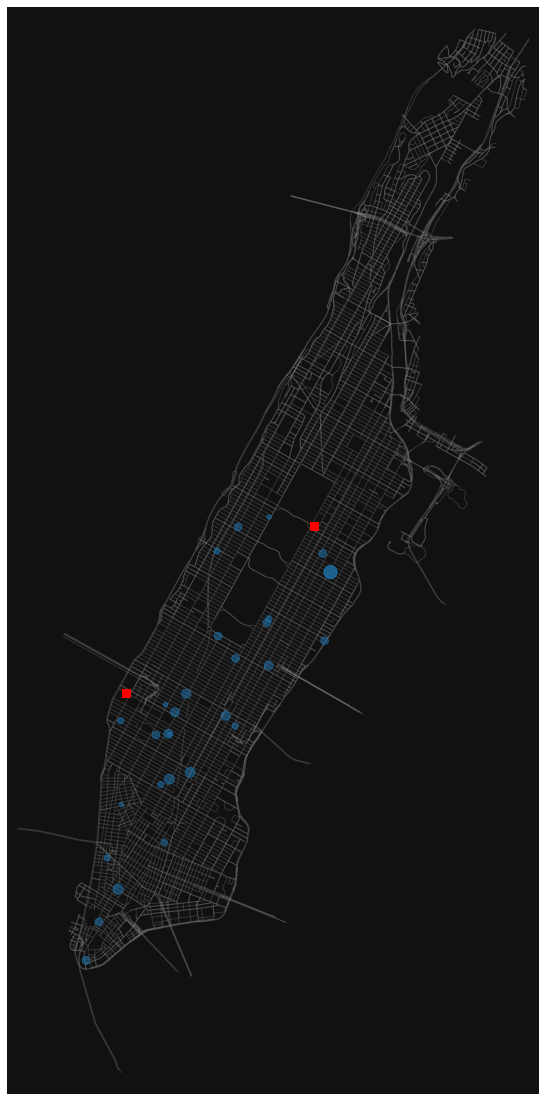

In [217]:
# Project the customer and depot data on the road network of Manhattan 
# (with a safety buffer of 500 meters around Manhattan) and plot it
myg, fig, ax = mapDataOSM(data,dep_locs, from_place = 'Manhattan', buffer_m=500)

### Create Objects
#### Customer Objects

Create dictionary of customer objects

In [218]:
customers = dict([
    (data.CustomerID.iloc[i],
     customer(data.lat.iloc[i],
              data.lng.iloc[i],
              data.CustomerID.iloc[i],
              data.OrderSize.iloc[i],
              s=data.ServiceTime.iloc[i])) for i in range(len(data))
])

Assign closest network nodes

In [219]:
for i in customers:
    customers[i].closestNetworkNode = int(data[data.CustomerID==i].closest_nw_node)

#### Depot Objects

Create dictionary of depot objects

In [220]:
depots = dict([
    (dep_locs.loc[i].DepotID,
     depot(dep_locs.lat.iloc[i],
           dep_locs.lng.iloc[i],
           'ro',
           dep_locs.DepotID.iloc[i])) for i in range(len(dep_locs))
])

Assign closest network nodes

In [221]:
for i in depots:
    depots[i].closestNetworkNode = int(dep_locs[dep_locs.DepotID==i].closest_nw_node)

#### Create joint set of customer and depot nodes

In [222]:
nodes = {**depots, **customers}

#### Vehicle Objects

Load vehicle data

In [223]:
vehicle_data_raw = pd.read_csv('SCM293_assignment01_vehicles.csv')
vehicle_data_raw

,type,c_fixed,c_distance,c_time,speed,capacity,max_range,max_time,N_available
0,conventional,42.5,16.25,20,27.5,15,80,1000,1000
1,LEFV,37.5,15.25,20,12.5,10,13,1000,1000


In [259]:
# Comment/uncomment the below depending on which vehicles you need in your model

vehicle_data = vehicle_data_raw[vehicle_data_raw.type=='conventional']
#vehicle_data = vehicle_data_raw[vehicle_data_raw.type=='LEFV']
#vehicle_data = vehicle_data_raw
#vehicle_data

Create dictionary of vehicle objects

In [260]:
vehicles = dict(
[(vehicle_data.iloc[i].type, vehicle(
        Q=vehicle_data.iloc[i].capacity,
        F=vehicle_data.iloc[i].c_fixed,
        cd=vehicle_data.iloc[i].c_distance/1000.0, # USD/km --> USD/meter
        ct=vehicle_data.iloc[i].c_time,
        v=vehicle_data.iloc[i].speed*1000.0, # km/hour --> meters/hour
        Tmax=vehicle_data.iloc[i].max_time, # hours
        Dmax=vehicle_data.iloc[i].max_range*1000.0, # km --> meters
        N=vehicle_data.iloc[i].N_available,
        pathstyle='-',
        vehtype_ID=vehicle_data.iloc[i].type)) 
 for i in range(len(vehicle_data))]
)

### Calculate Travel Distance & Time Matrices

Real OSM road network distance

In [261]:
distances_OSM, paths_OSM = d_matrix(nodes,myg,mode='OSM',returnPaths=True)

100%|██████████| 32/32 [00:00<00:00, 52.97it/s]


OSM travel times

In [262]:
times_OSM = t_matrix(distances_OSM,vehicles)

Use OSM distances moving forward

In [263]:
distances = distances_OSM
times = times_OSM

## Helper Function for Calculating KPI's

In [264]:
def starting_depots(X):
    start_depots = []
    for d in depots:
        for v in vehicles:
            for j in nodes:
                if round(X[(d,j,v,d)].x)==1:
                    start_depots.append(d)
    return start_depots
def number_of_routes_starting(start_depots):
    unique = dict(zip(start_depots,[start_depots.count(i) for i in start_depots]))
    return unique

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

def route_ldcu(routes,v):
    length = 0
    duration = 0
    cost = vehicles[v].F
    for i in range(len(routes)-1):
        segment_length = distances[(routes[i],routes[i+1])]
        segment_time = times[(routes[i],routes[i+1],v)]
        node_service = nodes[routes[i]].s
        length += segment_length
        duration += segment_time+node_service
        cost += segment_length*vehicles[v].cd+(segment_time+node_service)*vehicles[v].ct
        depot_n = routes[i][0]  
    demand = 0
    for i in range(1,len(routes)-1):
        demand += customers[routes[i]].q
    util = demand / vehicles[v].Q
    return {'Length':length,'Duration': duration, 'Cost': cost, 'Demand': demand, 'Utilization': util,
            'Vehicle_Type': v}
def meta_metrics(depots, nodes, vehicles, customers, X, m, multiple_vehicles=False):
    routes = []
    used_vehicles = []
    for d in depots:
        for v,w in enumerate(vehicles):
            for j in customers:
                if round(X[(d,j,w,d)].x) == 1:
                    path = [d,j]
                    locslist_x = [nodes[d].x, nodes[j].x]
                    locslist_y = [nodes[d].y, nodes[j].y]

                    jj = j

                    while not jj == d:
                        for i in nodes:
                            if round(X[(jj,i,w,d)].x) == 1:
                                path.append(i)
                                locslist_x.append(nodes[i].x)
                                locslist_y.append(nodes[i].y)
                                jj = i
                                break
                    routes.append(path)
                    used_vehicles.append(w)
    ldc_df = pd.DataFrame(columns = ['Length', 'Duration', 'Cost', 'Demand', 'Utilization', 'Vehicle_Type'])
    depots_n = []
    for i,j in enumerate(routes):
        for v in vehicles:
            if v==used_vehicles[i]:
                ldc_df = ldc_df.append(route_ldcu(j, v), ignore_index=True)  
                depots_n.append(routes[i][0])              
    ldc_df.insert(0, 'Depots_n', depots_n)
    ldc_df.insert(1, 'Route', routes)
    for i in range(len(routes)):
        print(f'Route {i}: \n {routes[i]}\n')
    print(ldc_df.Route[0])
    print(f'-----------------------------------\n')
    print(f'Total Cost of Operations: ${m.objVal:.2f} \n')
    print(f'-----------------------------------\n')
    if multiple_vehicles == False:
        print(f'Number of Routes Starting from Each Depot:\n')
        display(ldc_df.groupby(['Depots_n']).Route.count())
    else:
        print(f'Number of Routes Per Vehicle Type Starting from Each Depot:\n')
        display(ldc_df.groupby(['Depots_n', 'Vehicle_Type']).Route.count())
    print(f'-----------------------------------\n')
    print(f'Length, Duration, & Cost of Each Route:')
    display(ldc_df)
    print(f'-----------------------------------\n')
    if multiple_vehicles == False:
        print(f'Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot:')
        display(ldc_df.groupby(['Depots_n']).mean())
    else:
        print(f'Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot Per Vehicle Type:')
        display(ldc_df.groupby(['Depots_n', 'Vehicle_Type']).mean())
    print(f'-----------------------------------\n')
    print(f'Capacity Utilizations of Each Vehicle:\n')
    for i,j in enumerate(routes):
        for v in vehicles:
            if v==used_vehicles[i]:
                print(f'{v} vehicle with utilization: {(ldc_df.Demand[i]/vehicles[v].Q).round(2)} ')                
    print(f'\n All other vehicles have zero utilization')

## Gurobi Optimization Model

### Initialize New Gurobi Model

In [265]:
m = gp.Model("VRPAssignment1a")

### Add Decision Variables

In [266]:
X = dict(
    [((i,j,v,d), m.addVar(vtype=GRB.BINARY, lb=0.0, name="x_%s_%s_%s_%s" %(i,j,v,d))) 
     for i in nodes 
     for j in nodes
     for v in vehicles
     for d in depots]
)
Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

### Set Optimization Objective

Minimize total distance travelled

In [267]:
m.setObjective(
    quicksum([vehicles[v].F*X[(i,j,v,d)] 
              for i in depots
              for j in customers
              for v in vehicles
              for d in depots])
    + quicksum([((vehicles[v].cd*distances[(i,j)])+(vehicles[v].ct*times[(i,j,v)])+(vehicles[v].ct*nodes[i].s))
                *X[(i,j,v,d)]
              for i in nodes
              for j in nodes
              for v in vehicles
              for d in depots]), 
               GRB.MINIMIZE)

### Add Constraints

In [268]:
constraint_2 = dict(
    [(j,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles
     for i in nodes]) == 1, 
     f'constraint2_{j}')) 
     for j in customers]
)

constraint_3 = dict(
    [(i,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles 
     for j in nodes]) == 1, 
     f"constraint3_{i}")) 
     for i in customers]
)

constraint_4 = dict(
    [((v,j,d),m.addConstr(quicksum([X[(i,j,v,d)] for i in nodes])==
     quicksum([X[(j,i,v,d)] for i in nodes]), 
     f"constraint4_{v,j,d}"))
     for v in vehicles
     for j in nodes
     for d in depots]
)

constraint_5 = m.addConstr(quicksum([Y[(i,j)] for i in depots for j in customers])== 
     quicksum([customers[j].q for j in customers]),
    "constraint5")

constraint_6 = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes])-
     quicksum([Y[(j,i)] for i in nodes])==customers[j].q,
     f"const6_{j}")) 
     for j in customers]
)

constraint_7 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<= 
     quicksum([vehicles[v].Q*X[(i,j,v,d)] for d in depots for v in vehicles]), 
     f"constraint7_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_8 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(d_1,i,v,d_2)]==0,
     f"constraint8_{d_1,i,v,d_2}")) 
     for i in customers 
     for v in vehicles
     for d_1 in depots 
     for d_2 in depots if d_1 != d_2]
)

constraint_9 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(i,d_1,v,d_2)]==0,
     f"constraint9_{d_1,i,v,d_2}")) 
     for i in customers
     for v in vehicles
     for d_1 in depots
     for d_2 in depots 
     if d_1 != d_2]
)

constraint_11 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=0,
     f"constraint11_{i,j}")) 
     for i in nodes
     for j in nodes]
)

constraint_12 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<=quicksum([(vehicles[v].Q-
     nodes[i].q)*X[(i,j,v,d)] for d in depots for v in vehicles]),
     f"constraint12_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_13 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=
     quicksum([nodes[j].q*X[(i,j,v,d)]
     for d in depots for v in vehicles]),
     f"constraint13_{i,j}")) 
     for i in customers
     for j in customers]
)

constraint_14 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint14_{i,j}")) 
     for i in customers
     for j in depots]
)

constraint_15 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint15_{i,j}")) 
     for i in depots
     for j in depots]
)

constraint_16 = dict(
    [((i,i),m.addConstr(Y[(i,i)]==0,
     f"constraint16_{i,i}")) 
     for i in customers]
)

constraint_17 = dict(
    [((i,j,v,d),m.addConstr(X[(i,j,v,d)]==0,
     f"constraint17_{i,j,v,d}")) 
     for i in depots
     for j in depots
     for v in vehicles
     for d in depots]
)

constraint_18 = dict(
    [((i,i,v,d),m.addConstr(X[(i,i,v,d)]==0,
    f"constraint18_{i,i,v,d}")) 
     for i in depots
     for v in vehicles
     for d in depots]
)


### Run Optimization Model

In [269]:
m.reset()
m.update()

# Set model parameters
m.Params.timelimit = 3600.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.01          # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4225 rows, 3072 columns and 19438 nonzeros
Model fingerprint: 0x1b419ede
Variable types: 1024 continuous, 2048 integer (2048 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 2276 rows and 288 columns
Presolve time: 0.04s
Presolved: 1949 rows, 2784 columns, 14488 nonzeros
Variable types: 928 continuous, 1856 integer (1856 binary)
Found heuristic solution: objective 9554.5736304
Found heuristic solution: objective 6870.6154652

Root relaxation: objective 2.730024e+03, 1492 iterations, 0.0

## Analysis

### Calculate KPIs

In [270]:
meta_metrics(depots, nodes, vehicles, customers, X, m)

Route 0: 
 ['depS', 'af0fb51e-8d06-40be-af3e-b7d79ea6d0f2', '8a9798bc-16f2-4a27-bf64-53b2e163d438', 'c884efba-7538-423f-b9bf-58a80ad1d032', '2268dd03-fa81-4568-9a76-74f5c9af46e6', 'f0250c9a-e0f9-4dcd-bc00-9d16529c1071', 'depS']

Route 1: 
 ['depS', '5771797f-6a63-4ef4-abe9-827876aeebf1', '33d5073c-ae32-45df-9c52-242577b29771', 'a5bb2e12-d54b-49c4-bf2c-f53158622169', 'f65120c9-f245-4c59-8530-788d72cdc406', 'f05c5f0a-a34f-41e3-9541-3c364ccc2fa8', 'depS']

Route 2: 
 ['depS', 'bfc29e7d-e106-4e2c-8895-df3e9bbfd649', 'c9c83319-a969-4de3-8180-527174cefa27', '9748e2c2-ec8d-477c-8393-9cf2f5d3b481', '5b9b3014-9967-4701-be4f-c0cca18a2fbd', 'bd08b5b9-79e6-4947-b6e7-8e7b915060df', 'depS']

Route 3: 
 ['depS', 'd1830b2f-bfb4-4a00-8176-9e8753ace53f', '96cefc25-f246-4352-b000-795015d25dba', 'cc07cbb2-4ef5-4c0b-8963-829b8b68ed05', 'depS']

Route 4: 
 ['depN', 'db2beaa7-13c1-4424-a04c-158a176845e7', '04a590fc-f38f-48d7-b0f7-b8008e2b65dc', 'd076114c-5812-4b34-b596-0f61e7fe08bf', 'a43968f6-9e88-49cf-b1ef

Depots_n
depN    3
depS    4
Name: Route, dtype: int64

-----------------------------------

Length, Duration, & Cost of Each Route:


,Depots_n,Route,Length,Duration,Cost,Demand,Utilization,Vehicle_Type
0,depS,"[depS, af0fb51e-8d06-40be-af3e-b7d79ea6d0f2, 8...",8124.126,13.420,442.926,15.0,1.000,conventional
1,depS,"[depS, 5771797f-6a63-4ef4-abe9-827876aeebf1, 3...",6817.557,13.373,420.744,15.0,1.000,conventional
2,depS,"[depS, bfc29e7d-e106-4e2c-8895-df3e9bbfd649, c...",14112.610,13.638,544.594,15.0,1.000,conventional
3,depS,"[depS, d1830b2f-bfb4-4a00-8176-9e8753ace53f, 9...",3129.607,7.114,235.632,8.0,0.533,conventional
4,depN,"[depN, db2beaa7-13c1-4424-a04c-158a176845e7, 0...",9078.831,13.455,459.134,15.0,1.000,conventional
5,depN,"[depN, d1dccda7-d7bf-453d-b065-6fcbe6001e1b, a...",6945.237,10.503,365.411,14.0,0.933,conventional
6,depN,"[depN, 81ae301f-e02f-4868-bf37-9b5d135eea7f, d...",8123.778,10.545,385.420,15.0,1.000,conventional


-----------------------------------

Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot:


,Length,Duration,Cost,Demand,Utilization
Depots_n,,,,,
depN,8049.282,11.501,403.322,14.667,0.978
depS,8045.975,11.886,410.974,13.250,0.883


-----------------------------------

Capacity Utilizations of Each Vehicle:

conventional vehicle with utilization: 1.0 
conventional vehicle with utilization: 1.0 
conventional vehicle with utilization: 1.0 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 1.0 
conventional vehicle with utilization: 0.93 
conventional vehicle with utilization: 1.0 

 All other vehicles have zero utilization


# Part 1b)

In [271]:
vehicles['conventional'].Tmax=8
m = gp.Model("VRPAssignment1b")

In [272]:
######################
##Decision Variables##
######################
X = dict(
    [((i,j,v,d), m.addVar(vtype=GRB.BINARY, lb=0.0, name="x_%s_%s_%s_%s" %(i,j,v,d))) 
     for i in nodes 
     for j in nodes
     for v in vehicles
     for d in depots]
)

Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

T = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="t_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

######################
##Objective Function##
######################
m.setObjective(
    quicksum([vehicles[v].F*X[(i,j,v,d)] 
              for i in depots
              for j in customers
              for v in vehicles
              for d in depots])
    + quicksum([((vehicles[v].cd*distances[(i,j)])+(vehicles[v].ct*times[(i,j,v)])+(vehicles[v].ct*nodes[i].s))
                *X[(i,j,v,d)]
              for i in nodes
              for j in nodes
              for v in vehicles
              for d in depots]), 
               GRB.MINIMIZE)
###############
##Constraints##
###############
constraint_2 = dict(
    [(j,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles
     for i in nodes]) == 1, 
     f'constraint2_{j}')) 
     for j in customers]
)

constraint_3 = dict(
    [(i,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles 
     for j in nodes]) == 1, 
     f"constraint3_{i}")) 
     for i in customers]
)

constraint_4 = dict(
    [((v,j,d),m.addConstr(quicksum([X[(i,j,v,d)] for i in nodes])==
     quicksum([X[(j,i,v,d)] for i in nodes]), 
     f"constraint4_{v,j,d}"))
     for v in vehicles
     for j in nodes
     for d in depots]
)

constraint_5 = m.addConstr(quicksum([Y[(i,j)] for i in depots for j in customers])== 
     quicksum([customers[j].q for j in customers]),
    "constraint5")

constraint_6 = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes])-
     quicksum([Y[(j,i)] for i in nodes])==customers[j].q,
     f"const6_{j}")) 
     for j in customers]
)

constraint_7 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<= 
     quicksum([vehicles[v].Q*X[(i,j,v,d)] for d in depots for v in vehicles]), 
     f"constraint7_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_8 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(d_1,i,v,d_2)]==0,
     f"constraint8_{d_1,i,v,d_2}")) 
     for i in customers 
     for v in vehicles
     for d_1 in depots 
     for d_2 in depots if d_1 != d_2]
)

constraint_9 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(i,d_1,v,d_2)]==0,
     f"constraint9_{d_1,i,v,d_2}")) 
     for i in customers
     for v in vehicles
     for d_1 in depots
     for d_2 in depots 
     if d_1 != d_2]
)

constraint_11 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=0,
     f"constraint11_{i,j}")) 
     for i in nodes
     for j in nodes]
)

constraint_12 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<=quicksum([(vehicles[v].Q-
     nodes[i].q)*X[(i,j,v,d)] for d in depots for v in vehicles]),
     f"constraint12_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_13 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=
     quicksum([nodes[j].q*X[(i,j,v,d)]
     for d in depots for v in vehicles]),
     f"constraint13_{i,j}")) 
     for i in customers
     for j in customers]
)

constraint_14 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint14_{i,j}")) 
     for i in customers
     for j in depots]
)

constraint_15 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint15_{i,j}")) 
     for i in depots
     for j in depots]
)

constraint_16 = dict(
    [((i,i),m.addConstr(Y[(i,i)]==0,
     f"constraint16_{i,i}")) 
     for i in customers]
)

constraint_17 = dict(
    [((i,j,v,d),m.addConstr(X[(i,j,v,d)]==0,
     f"constraint17_{i,j,v,d}")) 
     for i in depots
     for j in depots
     for v in vehicles
     for d in depots]
)

constraint_18 = dict(
    [((i,i,v,d),m.addConstr(X[(i,i,v,d)]==0,
    f"constraint18_{i,i,v,d}")) 
     for i in depots
     for v in vehicles
     for d in depots]
)
################
#NEW CONSTRAINTS
################
constraint_22 = dict(
    [((i,d,v),m.addConstr(quicksum([T[(i,j,d,v)] for j in nodes if j!=i])-
    quicksum([T[(j,i,d,v)] for j in nodes if j!=i])==
    quicksum([(times[(i,j,v)]+nodes[i].s)*X[(i,j,v,d)] for j in nodes]), 
    f"constraint22_{i,d,v}")) 
    for i in customers
    for d in depots
    for v in vehicles]
)

constraint_23 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<= 
    (vehicles[v].Tmax-(times[(j,d,v)]+nodes[j].s))*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)
        
constraint_24 = dict(
    [((i,d,v),m.addConstr(T[(i,d,d,v)]<=vehicles[v].Tmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint_25 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=
     (times[(i,j,v)]+nodes[i].s+times[(d,i,v)]+nodes[d].s)*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint_26 = dict(
    [((i,d,v),m.addConstr(T[(d,i,d,v)]==
     (times[(d,i,v)]+nodes[d].s)*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint_27 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)  

constraint_28 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<=vehicles[v].Tmax*X[(i,j,v,d)],
     f"constraint_added_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

m.reset()
m.update()

# Set model parameters
m.Params.timelimit = 3600.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.04          # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.04
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12049 rows, 5120 columns and 38550 nonzeros
Model fingerprint: 0xa3d168e0
Variable types: 3072 continuous, 2048 integer (2048 binary)
Coefficient statistics:
  Matrix range     [2e-02, 2e+01]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 7480 rows and 1210 columns
Presolve time: 0.14s
Presolved: 4569 rows, 3910 columns, 23118 nonzeros
Variable types: 2238 continuous, 1672 integer (1672 binary)
Found heuristic solution: objective 9546.4665412
Found heuristic solution: objective 5704.9952900

Root relaxation: objective 3.262759e+03, 5242 iterations, 

In [273]:
meta_metrics(depots, nodes, vehicles, customers, X, m)

Route 0: 
 ['depS', 'f0250c9a-e0f9-4dcd-bc00-9d16529c1071', '5b9b3014-9967-4701-be4f-c0cca18a2fbd', 'bd08b5b9-79e6-4947-b6e7-8e7b915060df', 'depS']

Route 1: 
 ['depS', 'af0fb51e-8d06-40be-af3e-b7d79ea6d0f2', '8a9798bc-16f2-4a27-bf64-53b2e163d438', '96cefc25-f246-4352-b000-795015d25dba', 'depS']

Route 2: 
 ['depS', '5771797f-6a63-4ef4-abe9-827876aeebf1', '33d5073c-ae32-45df-9c52-242577b29771', 'f05c5f0a-a34f-41e3-9541-3c364ccc2fa8', 'depS']

Route 3: 
 ['depS', 'a5bb2e12-d54b-49c4-bf2c-f53158622169', 'f65120c9-f245-4c59-8530-788d72cdc406', 'depS']

Route 4: 
 ['depS', 'bfc29e7d-e106-4e2c-8895-df3e9bbfd649', 'c9c83319-a969-4de3-8180-527174cefa27', '9748e2c2-ec8d-477c-8393-9cf2f5d3b481', 'depS']

Route 5: 
 ['depS', 'd1830b2f-bfb4-4a00-8176-9e8753ace53f', 'cc07cbb2-4ef5-4c0b-8963-829b8b68ed05', 'depS']

Route 6: 
 ['depS', 'c884efba-7538-423f-b9bf-58a80ad1d032', '2268dd03-fa81-4568-9a76-74f5c9af46e6', 'depS']

Route 7: 
 ['depN', 'a55626c3-50ea-4ada-a1b1-dee9231c0d68', '5fcbca50-6547-45

Depots_n
depN    5
depS    7
Name: Route, dtype: int64

-----------------------------------

Length, Duration, & Cost of Each Route:


,Depots_n,Route,Length,Duration,Cost,Demand,Utilization,Vehicle_Type
0,depS,"[depS, f0250c9a-e0f9-4dcd-bc00-9d16529c1071, 5...",10038.704,7.365,352.930,8.0,0.533,conventional
1,depS,"[depS, af0fb51e-8d06-40be-af3e-b7d79ea6d0f2, 8...",5718.482,7.208,279.584,8.0,0.533,conventional
2,depS,"[depS, 5771797f-6a63-4ef4-abe9-827876aeebf1, 3...",6754.687,6.371,279.676,7.0,0.467,conventional
3,depS,"[depS, a5bb2e12-d54b-49c4-bf2c-f53158622169, f...",4085.486,7.149,251.860,8.0,0.533,conventional
4,depS,"[depS, bfc29e7d-e106-4e2c-8895-df3e9bbfd649, c...",13985.504,7.509,419.936,8.0,0.533,conventional
5,depS,"[depS, d1830b2f-bfb4-4a00-8176-9e8753ace53f, c...",3129.607,6.239,218.132,7.0,0.467,conventional
6,depS,"[depS, c884efba-7538-423f-b9bf-58a80ad1d032, 2...",6072.763,6.346,268.099,7.0,0.467,conventional
7,depN,"[depN, a55626c3-50ea-4ada-a1b1-dee9231c0d68, 5...",6945.237,7.878,312.911,11.0,0.733,conventional
8,depN,"[depN, 1b2a52ca-6048-47be-85ae-ed6968f828ec, d...",6423.743,5.484,256.558,6.0,0.400,conventional
9,depN,"[depN, db2beaa7-13c1-4424-a04c-158a176845e7, a...",7649.081,7.278,312.361,8.0,0.533,conventional


-----------------------------------

Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot:


,Length,Duration,Cost,Demand,Utilization
Depots_n,,,,,
depN,6443.884,6.959,286.400,8.800,0.587
depS,7112.176,6.884,295.745,7.571,0.505


-----------------------------------

Capacity Utilizations of Each Vehicle:

conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.73 
conventional vehicle with utilization: 0.4 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.8 
conventional vehicle with utilization: 0.47 

 All other vehicles have zero utilization


# Part 2)

In [274]:
vehicle_data = vehicle_data_raw[vehicle_data_raw.type=='LEFV']
vehicles = dict(
[(vehicle_data.iloc[i].type, vehicle(
        Q=vehicle_data.iloc[i].capacity,
        F=vehicle_data.iloc[i].c_fixed,
        cd=vehicle_data.iloc[i].c_distance/1000.0, # USD/km --> USD/meter
        ct=vehicle_data.iloc[i].c_time,
        v=vehicle_data.iloc[i].speed*1000.0, # km/hour --> meters/hour
        Tmax=vehicle_data.iloc[i].max_time, # hours
        Dmax=vehicle_data.iloc[i].max_range*1000.0, # km --> meters
        N=vehicle_data.iloc[i].N_available,
        pathstyle='-',
        vehtype_ID=vehicle_data.iloc[i].type)) 
 for i in range(len(vehicle_data))]
)
distances_OSM, paths_OSM = d_matrix(nodes,myg,mode='OSM',returnPaths=True)
times_OSM = t_matrix(distances_OSM,vehicles)
distances = distances_OSM
times = times_OSM

100%|██████████| 32/32 [00:00<00:00, 52.29it/s]


In [275]:
vehicles['LEFV'].Tmax=8
m = gp.Model("VRPAssignment2")

In [276]:
######################
##Decision Variables##
######################
X = dict(
    [((i,j,v,d), m.addVar(vtype=GRB.BINARY, lb=0.0, name="x_%s_%s_%s_%s" %(i,j,v,d))) 
     for i in nodes 
     for j in nodes
     for v in vehicles
     for d in depots]
)

Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

T = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="t_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

D = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="d_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

######################
##Objective Function##
######################
m.setObjective(
    quicksum([vehicles[v].F*X[(i,j,v,d)] 
              for i in depots
              for j in customers
              for v in vehicles
              for d in depots])
    + quicksum([((vehicles[v].cd*distances[(i,j)])+(vehicles[v].ct*times[(i,j,v)])+(vehicles[v].ct*nodes[i].s))
                *X[(i,j,v,d)]
              for i in nodes
              for j in nodes
              for v in vehicles
              for d in depots]), 
               GRB.MINIMIZE)
###############
##Constraints##
###############
constraint_2 = dict(
    [(j,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles
     for i in nodes]) == 1, 
     f'constraint2_{j}')) 
     for j in customers]
)

constraint_3 = dict(
    [(i,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles 
     for j in nodes]) == 1, 
     f"constraint3_{i}")) 
     for i in customers]
)

constraint_4 = dict(
    [((v,j,d),m.addConstr(quicksum([X[(i,j,v,d)] for i in nodes])==
     quicksum([X[(j,i,v,d)] for i in nodes]), 
     f"constraint4_{v,j,d}"))
     for v in vehicles
     for j in nodes
     for d in depots]
)

constraint_5 = m.addConstr(quicksum([Y[(i,j)] for i in depots for j in customers])== 
     quicksum([customers[j].q for j in customers]),
    "constraint5")

constraint_6 = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes])-
     quicksum([Y[(j,i)] for i in nodes])==customers[j].q,
     f"const6_{j}")) 
     for j in customers]
)

constraint_7 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<= 
     quicksum([vehicles[v].Q*X[(i,j,v,d)] for d in depots for v in vehicles]), 
     f"constraint7_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_8 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(d_1,i,v,d_2)]==0,
     f"constraint8_{d_1,i,v,d_2}")) 
     for i in customers 
     for v in vehicles
     for d_1 in depots 
     for d_2 in depots if d_1 != d_2]
)

constraint_9 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(i,d_1,v,d_2)]==0,
     f"constraint9_{d_1,i,v,d_2}")) 
     for i in customers
     for v in vehicles
     for d_1 in depots
     for d_2 in depots 
     if d_1 != d_2]
)

constraint_11 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=0,
     f"constraint11_{i,j}")) 
     for i in nodes
     for j in nodes]
)

constraint_12 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<=quicksum([(vehicles[v].Q-
     nodes[i].q)*X[(i,j,v,d)] for d in depots for v in vehicles]),
     f"constraint12_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_13 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=
     quicksum([nodes[j].q*X[(i,j,v,d)]
     for d in depots for v in vehicles]),
     f"constraint13_{i,j}")) 
     for i in customers
     for j in customers]
)

constraint_14 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint14_{i,j}")) 
     for i in customers
     for j in depots]
)

constraint_15 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint15_{i,j}")) 
     for i in depots
     for j in depots]
)

constraint_16 = dict(
    [((i,i),m.addConstr(Y[(i,i)]==0,
     f"constraint16_{i,i}")) 
     for i in customers]
)

constraint_17 = dict(
    [((i,j,v,d),m.addConstr(X[(i,j,v,d)]==0,
     f"constraint17_{i,j,v,d}")) 
     for i in depots
     for j in depots
     for v in vehicles
     for d in depots]
)

constraint_18 = dict(
    [((i,i,v,d),m.addConstr(X[(i,i,v,d)]==0,
    f"constraint18_{i,i,v,d}")) 
     for i in depots
     for v in vehicles
     for d in depots]
)

constraint_22 = dict(
    [((i,d,v),m.addConstr(quicksum([T[(i,j,d,v)] for j in nodes if j!=i])-
    quicksum([T[(j,i,d,v)] for j in nodes if j!=i])==
    quicksum([(times[(i,j,v)]+nodes[i].s)*X[(i,j,v,d)] for j in nodes]), 
    f"constraint22_{i,d,v}")) 
    for i in customers
    for d in depots
    for v in vehicles]
)

constraint_23 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<= 
    (vehicles[v].Tmax-(times[(j,d,v)]+nodes[j].s))*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)
        
constraint_24 = dict(
    [((i,d,v),m.addConstr(T[(i,d,d,v)]<=vehicles[v].Tmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint_25 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=
     (times[(i,j,v)]+nodes[i].s+times[(d,i,v)]+nodes[d].s)*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint_26 = dict(
    [((i,d,v),m.addConstr(T[(d,i,d,v)]==
     (times[(d,i,v)]+nodes[d].s)*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint_27 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)  

constraint_28 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<=vehicles[v].Tmax*X[(i,j,v,d)],
     f"constraint_added_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

###################
##NEW CONSTRAINTS##
###################
constraint22_2 = dict(
    [((i,d,v),m.addConstr(quicksum([D[(i,j,d,v)] for j in nodes if j!=i])- 
     quicksum([D[(j,i,d,v)] for j in nodes if j!=i])==
     quicksum([distances[(i,j)]*X[(i,j,v,d)] for j in nodes]),
     f"constraint22_{i,d,v}")) 
     for i in customers
     for d in depots
     for v in vehicles]
)

constraint23_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=(vehicles[v].Dmax - distances[(j,d)])*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)

constraint24_2 = dict(
    [((i,d,v),m.addConstr(D[(i,d,d,v)]<=vehicles[v].Dmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint25_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=(distances[(i,j)]+distances[(d,i)])*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint26_2 = dict(
    [((i,d,v),m.addConstr(D[(d,i,d,v)]==distances[(d,i)]*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint27_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)      

constraint28_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=vehicles[v].Dmax*X[(i,j,v,d)],
     f"constUnlisted1_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 


m.reset()
m.update()

# Set model parameters
m.Params.timelimit = 3600.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.025          # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.025
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19873 rows, 7168 columns and 57594 nonzeros
Model fingerprint: 0x892cb4c4
Variable types: 5120 continuous, 2048 integer (2048 binary)
Coefficient statistics:
  Matrix range     [5e-02, 2e+04]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 16022 rows and 4515 columns
Presolve time: 0.13s
Presolved: 3851 rows, 2653 columns, 15546 nonzeros
Variable types: 1885 continuous, 768 integer (767 binary)
Found heuristic solution: objective 7006.6981983
Found heuristic solution: objective 5978.7662736
Found heuristic solution: objective 5959.1872981

Root rela

In [277]:
meta_metrics(depots, nodes, vehicles, customers, X, m)

Route 0: 
 ['depS', '96cefc25-f246-4352-b000-795015d25dba', 'd1830b2f-bfb4-4a00-8176-9e8753ace53f', 'cc07cbb2-4ef5-4c0b-8963-829b8b68ed05', 'depS']

Route 1: 
 ['depS', 'f0250c9a-e0f9-4dcd-bc00-9d16529c1071', 'bfc29e7d-e106-4e2c-8895-df3e9bbfd649', '8a9798bc-16f2-4a27-bf64-53b2e163d438', 'depS']

Route 2: 
 ['depS', 'af0fb51e-8d06-40be-af3e-b7d79ea6d0f2', '5771797f-6a63-4ef4-abe9-827876aeebf1', '33d5073c-ae32-45df-9c52-242577b29771', 'depS']

Route 3: 
 ['depS', '5b9b3014-9967-4701-be4f-c0cca18a2fbd', 'bd08b5b9-79e6-4947-b6e7-8e7b915060df', 'depS']

Route 4: 
 ['depS', 'a5bb2e12-d54b-49c4-bf2c-f53158622169', 'f65120c9-f245-4c59-8530-788d72cdc406', 'depS']

Route 5: 
 ['depS', 'c9c83319-a969-4de3-8180-527174cefa27', '9748e2c2-ec8d-477c-8393-9cf2f5d3b481', 'depS']

Route 6: 
 ['depS', 'c884efba-7538-423f-b9bf-58a80ad1d032', '2268dd03-fa81-4568-9a76-74f5c9af46e6', 'f05c5f0a-a34f-41e3-9541-3c364ccc2fa8', 'depS']

Route 7: 
 ['depN', 'a43968f6-9e88-49cf-b1ef-4abc87aabb8c', '68c17b8c-6678-44

Depots_n
depN    6
depS    7
Name: Route, dtype: int64

-----------------------------------

Length, Duration, & Cost of Each Route:


,Depots_n,Route,Length,Duration,Cost,Demand,Utilization,Vehicle_Type
0,depS,"[depS, 96cefc25-f246-4352-b000-795015d25dba, d...",3129.607,7.250,230.234,8.0,0.8,LEFV
1,depS,"[depS, f0250c9a-e0f9-4dcd-bc00-9d16529c1071, b...",9440.155,7.755,336.567,8.0,0.8,LEFV
2,depS,"[depS, af0fb51e-8d06-40be-af3e-b7d79ea6d0f2, 5...",7672.343,7.614,306.779,8.0,0.8,LEFV
3,depS,"[depS, 5b9b3014-9967-4701-be4f-c0cca18a2fbd, b...",9554.480,6.889,320.993,7.0,0.7,LEFV
4,depS,"[depS, a5bb2e12-d54b-49c4-bf2c-f53158622169, f...",4085.486,7.327,246.340,8.0,0.8,LEFV
5,depS,"[depS, c9c83319-a969-4de3-8180-527174cefa27, 9...",12904.782,6.282,359.946,6.0,0.6,LEFV
6,depS,"[depS, c884efba-7538-423f-b9bf-58a80ad1d032, 2...",6409.529,7.513,285.501,8.0,0.8,LEFV
7,depN,"[depN, a43968f6-9e88-49cf-b1ef-4abc87aabb8c, 6...",7597.508,7.608,305.518,8.0,0.8,LEFV
8,depN,"[depN, a55626c3-50ea-4ada-a1b1-dee9231c0d68, d...",3285.503,5.263,192.861,8.0,0.8,LEFV
9,depN,"[depN, db2beaa7-13c1-4424-a04c-158a176845e7, 1...",9132.831,7.731,331.388,8.0,0.8,LEFV


-----------------------------------

Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot:


,Length,Duration,Cost,Demand,Utilization
Depots_n,,,,,
depN,5792.833,6.068,247.193,7.333,0.733
depS,7599.483,7.233,298.051,7.571,0.757


-----------------------------------

Capacity Utilizations of Each Vehicle:

LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.7 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.6 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.3 
LEFV vehicle with utilization: 0.9 
LEFV vehicle with utilization: 0.8 

 All other vehicles have zero utilization


# Part 3a: Optimal Fleet Assignment

In [278]:
vehicle_data = vehicle_data_raw
vehicles = dict(
[(vehicle_data.iloc[i].type, vehicle(
        Q=vehicle_data.iloc[i].capacity,
        F=vehicle_data.iloc[i].c_fixed,
        cd=vehicle_data.iloc[i].c_distance/1000.0, # USD/km --> USD/meter
        ct=vehicle_data.iloc[i].c_time,
        v=vehicle_data.iloc[i].speed*1000.0, # km/hour --> meters/hour
        Tmax=vehicle_data.iloc[i].max_time, # hours
        Dmax=vehicle_data.iloc[i].max_range*1000.0, # km --> meters
        N=vehicle_data.iloc[i].N_available,
        pathstyle='-',
        vehtype_ID=vehicle_data.iloc[i].type)) 
 for i in range(len(vehicle_data))]
)
distances_OSM, paths_OSM = d_matrix(nodes,myg,mode='OSM',returnPaths=True)
times_OSM = t_matrix(distances_OSM,vehicles)
distances = distances_OSM
times = times_OSM

vehicles['conventional'].Tmax = 8
vehicles['LEFV'].Tmax = 8

m = gp.Model("VRPAssignment3a")

100%|██████████| 32/32 [00:00<00:00, 52.68it/s]


In [279]:
######################
##Decision Variables##
######################
X = dict(
    [((i,j,v,d), m.addVar(vtype=GRB.BINARY, lb=0.0, name="x_%s_%s_%s_%s" %(i,j,v,d))) 
     for i in nodes 
     for j in nodes
     for v in vehicles
     for d in depots]
)

Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

T = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="t_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

D = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="d_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

######################
##Objective Function##
######################
m.setObjective(
    quicksum([vehicles[v].F*X[(i,j,v,d)] 
              for i in depots
              for j in customers
              for v in vehicles
              for d in depots])
    + quicksum([((vehicles[v].cd*distances[(i,j)])+(vehicles[v].ct*times[(i,j,v)])+(vehicles[v].ct*nodes[i].s))
                *X[(i,j,v,d)]
              for i in nodes
              for j in nodes
              for v in vehicles
              for d in depots]), 
               GRB.MINIMIZE)
###############
##Constraints##
###############
constraint_2 = dict(
    [(j,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles
     for i in nodes]) == 1, 
     f'constraint2_{j}')) 
     for j in customers]
)

constraint_3 = dict(
    [(i,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles 
     for j in nodes]) == 1, 
     f"constraint3_{i}")) 
     for i in customers]
)

constraint_4 = dict(
    [((v,j,d),m.addConstr(quicksum([X[(i,j,v,d)] for i in nodes])==
     quicksum([X[(j,i,v,d)] for i in nodes]), 
     f"constraint4_{v,j,d}"))
     for v in vehicles
     for j in nodes
     for d in depots]
)

constraint_5 = m.addConstr(quicksum([Y[(i,j)] for i in depots for j in customers])== 
     quicksum([customers[j].q for j in customers]),
    "constraint5")

constraint_6 = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes])-
     quicksum([Y[(j,i)] for i in nodes])==customers[j].q,
     f"const6_{j}")) 
     for j in customers]
)

constraint_7 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<= 
     quicksum([vehicles[v].Q*X[(i,j,v,d)] for d in depots for v in vehicles]), 
     f"constraint7_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_8 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(d_1,i,v,d_2)]==0,
     f"constraint8_{d_1,i,v,d_2}")) 
     for i in customers 
     for v in vehicles
     for d_1 in depots 
     for d_2 in depots if d_1 != d_2]
)

constraint_9 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(i,d_1,v,d_2)]==0,
     f"constraint9_{d_1,i,v,d_2}")) 
     for i in customers
     for v in vehicles
     for d_1 in depots
     for d_2 in depots 
     if d_1 != d_2]
)

constraint_11 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=0,
     f"constraint11_{i,j}")) 
     for i in nodes
     for j in nodes]
)

constraint_12 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<=quicksum([(vehicles[v].Q-
     nodes[i].q)*X[(i,j,v,d)] for d in depots for v in vehicles]),
     f"constraint12_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_13 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=
     quicksum([nodes[j].q*X[(i,j,v,d)]
     for d in depots for v in vehicles]),
     f"constraint13_{i,j}")) 
     for i in customers
     for j in customers]
)

constraint_14 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint14_{i,j}")) 
     for i in customers
     for j in depots]
)

constraint_15 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint15_{i,j}")) 
     for i in depots
     for j in depots]
)

constraint_16 = dict(
    [((i,i),m.addConstr(Y[(i,i)]==0,
     f"constraint16_{i,i}")) 
     for i in customers]
)

constraint_17 = dict(
    [((i,j,v,d),m.addConstr(X[(i,j,v,d)]==0,
     f"constraint17_{i,j,v,d}")) 
     for i in depots
     for j in depots
     for v in vehicles
     for d in depots]
)

constraint_18 = dict(
    [((i,i,v,d),m.addConstr(X[(i,i,v,d)]==0,
    f"constraint18_{i,i,v,d}")) 
     for i in depots
     for v in vehicles
     for d in depots]
)

constraint_22 = dict(
    [((i,d,v),m.addConstr(quicksum([T[(i,j,d,v)] for j in nodes if j!=i])-
    quicksum([T[(j,i,d,v)] for j in nodes if j!=i])==
    quicksum([(times[(i,j,v)]+nodes[i].s)*X[(i,j,v,d)] for j in nodes]), 
    f"constraint22_{i,d,v}")) 
    for i in customers
    for d in depots
    for v in vehicles]
)

constraint_23 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<= 
    (vehicles[v].Tmax-(times[(j,d,v)]+nodes[j].s))*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)
        
constraint_24 = dict(
    [((i,d,v),m.addConstr(T[(i,d,d,v)]<=vehicles[v].Tmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint_25 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=
     (times[(i,j,v)]+nodes[i].s+times[(d,i,v)]+nodes[d].s)*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint_26 = dict(
    [((i,d,v),m.addConstr(T[(d,i,d,v)]==
     (times[(d,i,v)]+nodes[d].s)*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint_27 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)  

constraint_28 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<=vehicles[v].Tmax*X[(i,j,v,d)],
     f"constraint_added_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

constraint22_2 = dict(
    [((i,d,v),m.addConstr(quicksum([D[(i,j,d,v)] for j in nodes if j!=i])- 
     quicksum([D[(j,i,d,v)] for j in nodes if j!=i])==
     quicksum([distances[(i,j)]*X[(i,j,v,d)] for j in nodes]),
     f"constraint22_{i,d,v}")) 
     for i in customers
     for d in depots
     for v in vehicles]
)

constraint23_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=(vehicles[v].Dmax - distances[(j,d)])*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)

constraint24_2 = dict(
    [((i,d,v),m.addConstr(D[(i,d,d,v)]<=vehicles[v].Dmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint25_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=(distances[(i,j)]+distances[(d,i)])*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint26_2 = dict(
    [((i,d,v),m.addConstr(D[(d,i,d,v)]>=distances[(d,i)]*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint27_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)      

constraint28_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=vehicles[v].Dmax*X[(i,j,v,d)],
     f"constUnlisted1_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 


m.reset()
m.update()

# Set model parameters
m.Params.timelimit = 3600.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.035          # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.035
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35717 rows, 13312 columns and 109330 nonzeros
Model fingerprint: 0x11acc9c3
Variable types: 9216 continuous, 4096 integer (4096 binary)
Coefficient statistics:
  Matrix range     [2e-02, 8e+04]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 24747 rows and 5457 columns
Presolve time: 0.27s
Presolved: 10970 rows, 7855 columns, 49159 nonzeros
Variable types: 5413 continuous, 2442 integer (2442 binary)
Found heuristic solution: objective 9546.4665412
Found heuristic solution: objective 5842.7269527

Root relaxation: objective 3.250747e+03, 9243 iterati

  1460   941 3330.73875   16  231 3449.86050 3319.36421  3.78%   235   30s
  1477   952 3395.98220   25  256 3449.86050 3326.36175  3.58%   233   35s

Cutting planes:
  Learned: 5
  Gomory: 1
  Cover: 4
  Implied bound: 15
  Projected implied bound: 16
  Clique: 1
  MIR: 105
  Flow cover: 105
  GUB cover: 29
  Zero half: 3
  RLT: 14
  Relax-and-lift: 52

Explored 1484 nodes (393567 simplex iterations) in 37.15 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 3449.86 3449.96 3464.51 ... 3629.58

Optimal solution found (tolerance 3.50e-02)
Best objective 3.449860504168e+03, best bound 3.329334620608e+03, gap 3.4936%


In [280]:
meta_metrics(depots, nodes, vehicles, customers, X, m, multiple_vehicles=True)

Route 0: 
 ['depS', 'bfc29e7d-e106-4e2c-8895-df3e9bbfd649', 'c9c83319-a969-4de3-8180-527174cefa27', '9748e2c2-ec8d-477c-8393-9cf2f5d3b481', 'depS']

Route 1: 
 ['depS', 'f0250c9a-e0f9-4dcd-bc00-9d16529c1071', '5b9b3014-9967-4701-be4f-c0cca18a2fbd', 'bd08b5b9-79e6-4947-b6e7-8e7b915060df', 'depS']

Route 2: 
 ['depS', 'af0fb51e-8d06-40be-af3e-b7d79ea6d0f2', '8a9798bc-16f2-4a27-bf64-53b2e163d438', '96cefc25-f246-4352-b000-795015d25dba', 'depS']

Route 3: 
 ['depS', '5771797f-6a63-4ef4-abe9-827876aeebf1', '33d5073c-ae32-45df-9c52-242577b29771', 'f05c5f0a-a34f-41e3-9541-3c364ccc2fa8', 'depS']

Route 4: 
 ['depS', 'a5bb2e12-d54b-49c4-bf2c-f53158622169', 'f65120c9-f245-4c59-8530-788d72cdc406', 'depS']

Route 5: 
 ['depS', 'd1830b2f-bfb4-4a00-8176-9e8753ace53f', 'cc07cbb2-4ef5-4c0b-8963-829b8b68ed05', 'depS']

Route 6: 
 ['depS', 'c884efba-7538-423f-b9bf-58a80ad1d032', '2268dd03-fa81-4568-9a76-74f5c9af46e6', 'depS']

Route 7: 
 ['depN', 'a55626c3-50ea-4ada-a1b1-dee9231c0d68', '5fcbca50-6547-45

Depots_n  Vehicle_Type
depN      LEFV            3
          conventional    2
depS      LEFV            6
          conventional    1
Name: Route, dtype: int64

-----------------------------------

Length, Duration, & Cost of Each Route:


,Depots_n,Route,Length,Duration,Cost,Demand,Utilization,Vehicle_Type
0,depS,"[depS, bfc29e7d-e106-4e2c-8895-df3e9bbfd649, c...",13985.504,7.509,419.936,8.0,0.533,conventional
1,depS,"[depS, f0250c9a-e0f9-4dcd-bc00-9d16529c1071, 5...",10038.704,7.803,346.652,8.0,0.800,LEFV
2,depS,"[depS, af0fb51e-8d06-40be-af3e-b7d79ea6d0f2, 8...",5718.482,7.457,273.856,8.0,0.800,LEFV
3,depS,"[depS, 5771797f-6a63-4ef4-abe9-827876aeebf1, 3...",6754.687,6.665,273.816,7.0,0.700,LEFV
4,depS,"[depS, a5bb2e12-d54b-49c4-bf2c-f53158622169, f...",4085.486,7.327,246.340,8.0,0.800,LEFV
5,depS,"[depS, d1830b2f-bfb4-4a00-8176-9e8753ace53f, c...",3129.607,6.375,212.734,7.0,0.700,LEFV
6,depS,"[depS, c884efba-7538-423f-b9bf-58a80ad1d032, 2...",6072.763,6.611,262.326,7.0,0.700,LEFV
7,depN,"[depN, a55626c3-50ea-4ada-a1b1-dee9231c0d68, 5...",6945.237,7.878,312.911,11.0,0.733,conventional
8,depN,"[depN, d1dccda7-d7bf-453d-b065-6fcbe6001e1b, 0...",3285.503,7.744,250.779,12.0,0.800,conventional
9,depN,"[depN, 1b2a52ca-6048-47be-85ae-ed6968f828ec, d...",6423.743,5.764,250.740,6.0,0.600,LEFV


-----------------------------------

Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot Per Vehicle Type:


Length    Duration   Cost    Demand  Utilization
Depots_n Vehicle_Type                                                   
depN     LEFV           7329.561    6.711   283.503    7.0      0.700   
         conventional   5115.370    7.811   281.845   11.5      0.767   
depS     LEFV           5966.622    7.040   269.288    7.5      0.750   
         conventional  13985.504    7.509   419.936    8.0      0.533

-----------------------------------

Capacity Utilizations of Each Vehicle:

conventional vehicle with utilization: 0.53 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.7 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.7 
LEFV vehicle with utilization: 0.7 
conventional vehicle with utilization: 0.73 
conventional vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.6 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.7 

 All other vehicles have zero utilization


# Part 3b: Supplier Issues

In [281]:
vehicle_data = vehicle_data_raw
vehicles = dict(
[(vehicle_data.iloc[i].type, vehicle(
        Q=vehicle_data.iloc[i].capacity,
        F=vehicle_data.iloc[i].c_fixed,
        cd=vehicle_data.iloc[i].c_distance/1000.0, # USD/km --> USD/meter
        ct=vehicle_data.iloc[i].c_time,
        v=vehicle_data.iloc[i].speed*1000.0, # km/hour --> meters/hour
        Tmax=vehicle_data.iloc[i].max_time, # hours
        Dmax=vehicle_data.iloc[i].max_range*1000.0, # km --> meters
        N=vehicle_data.iloc[i].N_available,
        pathstyle='-',
        vehtype_ID=vehicle_data.iloc[i].type)) 
 for i in range(len(vehicle_data))]
)
distances_OSM, paths_OSM = d_matrix(nodes,myg,mode='OSM',returnPaths=True)
times_OSM = t_matrix(distances_OSM,vehicles)
distances = distances_OSM
times = times_OSM

vehicles['conventional'].Tmax = 8
vehicles['LEFV'].Tmax = 8
vehicles['LEFV'].N = 4
m = gp.Model("VRPAssignment3b")

100%|██████████| 32/32 [00:00<00:00, 53.10it/s]


In [282]:
######################
##Decision Variables##
######################
X = dict(
    [((i,j,v,d), m.addVar(vtype=GRB.BINARY, lb=0.0, name="x_%s_%s_%s_%s" %(i,j,v,d))) 
     for i in nodes 
     for j in nodes
     for v in vehicles
     for d in depots]
)

Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

T = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="t_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

D = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="d_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

######################
##Objective Function##
######################
m.setObjective(
    quicksum([vehicles[v].F*X[(i,j,v,d)] 
              for i in depots
              for j in customers
              for v in vehicles
              for d in depots])
    + quicksum([((vehicles[v].cd*distances[(i,j)])+(vehicles[v].ct*times[(i,j,v)])+(vehicles[v].ct*nodes[i].s))
                *X[(i,j,v,d)]
              for i in nodes
              for j in nodes
              for v in vehicles
              for d in depots]), 
               GRB.MINIMIZE)
###############
##Constraints##
###############
constraint_2 = dict(
    [(j,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles
     for i in nodes]) == 1, 
     f'constraint2_{j}')) 
     for j in customers]
)

constraint_3 = dict(
    [(i,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles 
     for j in nodes]) == 1, 
     f"constraint3_{i}")) 
     for i in customers]
)

constraint_4 = dict(
    [((v,j,d),m.addConstr(quicksum([X[(i,j,v,d)] for i in nodes])==
     quicksum([X[(j,i,v,d)] for i in nodes]), 
     f"constraint4_{v,j,d}"))
     for v in vehicles
     for j in nodes
     for d in depots]
)

constraint_5 = m.addConstr(quicksum([Y[(i,j)] for i in depots for j in customers])== 
     quicksum([customers[j].q for j in customers]),
    "constraint5")

constraint_6 = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes])-
     quicksum([Y[(j,i)] for i in nodes])==customers[j].q,
     f"const6_{j}")) 
     for j in customers]
)

constraint_7 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<= 
     quicksum([vehicles[v].Q*X[(i,j,v,d)] for d in depots for v in vehicles]), 
     f"constraint7_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_8 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(d_1,i,v,d_2)]==0,
     f"constraint8_{d_1,i,v,d_2}")) 
     for i in customers 
     for v in vehicles
     for d_1 in depots 
     for d_2 in depots if d_1 != d_2]
)

constraint_9 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(i,d_1,v,d_2)]==0,
     f"constraint9_{d_1,i,v,d_2}")) 
     for i in customers
     for v in vehicles
     for d_1 in depots
     for d_2 in depots 
     if d_1 != d_2]
)

constraint_11 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=0,
     f"constraint11_{i,j}")) 
     for i in nodes
     for j in nodes]
)

constraint_12 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<=quicksum([(vehicles[v].Q-
     nodes[i].q)*X[(i,j,v,d)] for d in depots for v in vehicles]),
     f"constraint12_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_13 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=
     quicksum([nodes[j].q*X[(i,j,v,d)]
     for d in depots for v in vehicles]),
     f"constraint13_{i,j}")) 
     for i in customers
     for j in customers]
)

constraint_14 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint14_{i,j}")) 
     for i in customers
     for j in depots]
)

constraint_15 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint15_{i,j}")) 
     for i in depots
     for j in depots]
)

constraint_16 = dict(
    [((i,i),m.addConstr(Y[(i,i)]==0,
     f"constraint16_{i,i}")) 
     for i in customers]
)

constraint_17 = dict(
    [((i,j,v,d),m.addConstr(X[(i,j,v,d)]==0,
     f"constraint17_{i,j,v,d}")) 
     for i in depots
     for j in depots
     for v in vehicles
     for d in depots]
)

constraint_18 = dict(
    [((i,i,v,d),m.addConstr(X[(i,i,v,d)]==0,
    f"constraint18_{i,i,v,d}")) 
     for i in depots
     for v in vehicles
     for d in depots]
)

constraint_22 = dict(
    [((i,d,v),m.addConstr(quicksum([T[(i,j,d,v)] for j in nodes if j!=i])-
    quicksum([T[(j,i,d,v)] for j in nodes if j!=i])==
    quicksum([(times[(i,j,v)]+nodes[i].s)*X[(i,j,v,d)] for j in nodes]), 
    f"constraint22_{i,d,v}")) 
    for i in customers
    for d in depots
    for v in vehicles]
)

constraint_23 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<= 
    (vehicles[v].Tmax-(times[(j,d,v)]+nodes[j].s))*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)
        
constraint_24 = dict(
    [((i,d,v),m.addConstr(T[(i,d,d,v)]<=vehicles[v].Tmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint_25 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=
     (times[(i,j,v)]+nodes[i].s+times[(d,i,v)]+nodes[d].s)*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint_26 = dict(
    [((i,d,v),m.addConstr(T[(d,i,d,v)]==
     (times[(d,i,v)]+nodes[d].s)*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint_27 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)  

constraint_28 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<=vehicles[v].Tmax*X[(i,j,v,d)],
     f"constraint_added_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

constraint22_2 = dict(
    [((i,d,v),m.addConstr(quicksum([D[(i,j,d,v)] for j in nodes if j!=i])- 
     quicksum([D[(j,i,d,v)] for j in nodes if j!=i])==
     quicksum([distances[(i,j)]*X[(i,j,v,d)] for j in nodes]),
     f"constraint22_{i,d,v}")) 
     for i in customers
     for d in depots
     for v in vehicles]
)

constraint23_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=(vehicles[v].Dmax - distances[(j,d)])*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)

constraint24_2 = dict(
    [((i,d,v),m.addConstr(D[(i,d,d,v)]<=vehicles[v].Dmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint25_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=(distances[(i,j)]+distances[(d,i)])*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint26_2 = dict(
    [((i,d,v),m.addConstr(D[(d,i,d,v)]>=distances[(d,i)]*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint27_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)      

constraint28_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=vehicles[v].Dmax*X[(i,j,v,d)],
     f"constUnlisted1_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

################
#NEW COSNTRAINT#
################

constraint18_sec2_5 = dict(
    [((v),m.addConstr(quicksum([X[(i,j,v,d)] for d in depots for i in depots for j in customers])<=
     vehicles[v].N,
     f"constraint18_sec2_5_{v}"))
     for v in vehicles]
) 
   

m.reset()
m.update()

# Set model parameters
m.Params.timelimit = 3600.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.04          # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.04
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35719 rows, 13312 columns and 109570 nonzeros
Model fingerprint: 0x071bb72b
Variable types: 9216 continuous, 4096 integer (4096 binary)
Coefficient statistics:
  Matrix range     [2e-02, 8e+04]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 24748 rows and 5457 columns
Presolve time: 0.26s
Presolved: 10971 rows, 7855 columns, 49206 nonzeros
Variable types: 5413 continuous, 2442 integer (2442 binary)
Found heuristic solution: objective 9546.4665412
Found heuristic solution: objective 5842.7269527

Root relaxation: objective 3.251531e+03, 10477 iterati

H  183   181                    3478.3427725 3319.53017  4.57%   322   14s
H  192   181                    3478.3012808 3319.53017  4.56%   314   14s
H  228   197                    3478.2729287 3319.91044  4.55%   288   14s
H  229   197                    3478.1454791 3319.91044  4.55%   287   14s
   256   234 3341.70546    5  192 3478.14548 3321.11791  4.51%   284   15s
  1005   727 3414.15410   32   60 3478.14548 3322.80670  4.47%   198   20s
H 1059   749                    3478.1171271 3322.80670  4.47%   197   20s
H 1081   748                    3478.0970599 3322.80670  4.46%   195   20s
  1449   970 3366.00433   11  240 3478.09706 3323.96384  4.43%   187   28s
H 1450   922                    3478.0970312 3323.96384  4.43%   186   29s
  1452   923 3337.30772   10  148 3478.09703 3323.96384  4.43%   186   31s
  1470   935 3349.09431   18  222 3478.09703 3324.37251  4.42%   184   35s
  1493   950 3380.62755   31  283 3478.09703 3328.56715  4.30%   181   41s
  1504   958 3416.26466  

In [283]:
meta_metrics(depots, nodes, vehicles, customers, X, m, multiple_vehicles=True)

Route 0: 
 ['depS', '96cefc25-f246-4352-b000-795015d25dba', 'd1830b2f-bfb4-4a00-8176-9e8753ace53f', 'cc07cbb2-4ef5-4c0b-8963-829b8b68ed05', 'depS']

Route 1: 
 ['depS', 'af0fb51e-8d06-40be-af3e-b7d79ea6d0f2', '8a9798bc-16f2-4a27-bf64-53b2e163d438', 'depS']

Route 2: 
 ['depS', 'a5bb2e12-d54b-49c4-bf2c-f53158622169', 'f65120c9-f245-4c59-8530-788d72cdc406', 'depS']

Route 3: 
 ['depS', 'bfc29e7d-e106-4e2c-8895-df3e9bbfd649', 'c9c83319-a969-4de3-8180-527174cefa27', '9748e2c2-ec8d-477c-8393-9cf2f5d3b481', 'depS']

Route 4: 
 ['depS', 'c884efba-7538-423f-b9bf-58a80ad1d032', '2268dd03-fa81-4568-9a76-74f5c9af46e6', 'depS']

Route 5: 
 ['depS', 'f0250c9a-e0f9-4dcd-bc00-9d16529c1071', '5b9b3014-9967-4701-be4f-c0cca18a2fbd', 'bd08b5b9-79e6-4947-b6e7-8e7b915060df', 'depS']

Route 6: 
 ['depS', '5771797f-6a63-4ef4-abe9-827876aeebf1', '33d5073c-ae32-45df-9c52-242577b29771', 'f05c5f0a-a34f-41e3-9541-3c364ccc2fa8', 'depS']

Route 7: 
 ['depN', '1b2a52ca-6048-47be-85ae-ed6968f828ec', 'dacb2a58-a8b9-41

Depots_n  Vehicle_Type
depN      LEFV            2
          conventional    3
depS      LEFV            2
          conventional    5
Name: Route, dtype: int64

-----------------------------------

Length, Duration, & Cost of Each Route:


,Depots_n,Route,Length,Duration,Cost,Demand,Utilization,Vehicle_Type
0,depS,"[depS, 96cefc25-f246-4352-b000-795015d25dba, d...",3129.607,7.114,235.632,8.0,0.533,conventional
1,depS,"[depS, af0fb51e-8d06-40be-af3e-b7d79ea6d0f2, 8...",5718.482,6.333,262.084,7.0,0.467,conventional
2,depS,"[depS, a5bb2e12-d54b-49c4-bf2c-f53158622169, f...",4085.486,7.149,251.860,8.0,0.533,conventional
3,depS,"[depS, bfc29e7d-e106-4e2c-8895-df3e9bbfd649, c...",13985.504,7.509,419.936,8.0,0.533,conventional
4,depS,"[depS, c884efba-7538-423f-b9bf-58a80ad1d032, 2...",6072.763,6.346,268.099,7.0,0.467,conventional
5,depS,"[depS, f0250c9a-e0f9-4dcd-bc00-9d16529c1071, 5...",10038.704,7.803,346.652,8.0,0.800,LEFV
6,depS,"[depS, 5771797f-6a63-4ef4-abe9-827876aeebf1, 3...",6754.687,6.665,273.816,7.0,0.700,LEFV
7,depN,"[depN, 1b2a52ca-6048-47be-85ae-ed6968f828ec, d...",6423.743,5.484,256.558,6.0,0.400,conventional
8,depN,"[depN, d1dccda7-d7bf-453d-b065-6fcbe6001e1b, a...",3285.503,7.744,250.779,11.0,0.733,conventional
9,depN,"[depN, 09b405aa-78dd-45f3-91c2-e26c4c7b9f09, 5...",6945.237,7.878,312.911,12.0,0.800,conventional


-----------------------------------

Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot Per Vehicle Type:


Length   Duration   Cost    Demand  Utilization
Depots_n Vehicle_Type                                                  
depN     LEFV          7782.470    7.185   299.885   7.500     0.750   
         conventional  5551.494    7.035   273.416   9.667     0.644   
depS     LEFV          8396.696    7.234   310.234   7.500     0.750   
         conventional  6598.368    6.890   287.522   7.600     0.507

-----------------------------------

Capacity Utilizations of Each Vehicle:

conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.47 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.7 
conventional vehicle with utilization: 0.4 
conventional vehicle with utilization: 0.73 
conventional vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.7 

 All other vehicles have zero utilization


# Part 4: Time-based access restrictions for commercial vehicles

In [284]:
vehicle_data = vehicle_data_raw
vehicles = dict(
[(vehicle_data.iloc[i].type, vehicle(
        Q=vehicle_data.iloc[i].capacity,
        F=vehicle_data.iloc[i].c_fixed,
        cd=vehicle_data.iloc[i].c_distance/1000.0, # USD/km --> USD/meter
        ct=vehicle_data.iloc[i].c_time,
        v=vehicle_data.iloc[i].speed*1000.0, # km/hour --> meters/hour
        Tmax=vehicle_data.iloc[i].max_time, # hours
        Dmax=vehicle_data.iloc[i].max_range*1000.0, # km --> meters
        N=vehicle_data.iloc[i].N_available,
        pathstyle='-',
        vehtype_ID=vehicle_data.iloc[i].type)) 
 for i in range(len(vehicle_data))]
)
distances_OSM, paths_OSM = d_matrix(nodes,myg,mode='OSM',returnPaths=True)
times_OSM = t_matrix(distances_OSM,vehicles)
distances = distances_OSM
times = times_OSM


vehicles['LEFV'].Tmax = 8
vehicles['LEFV'].N = 1000
vehicles['conventional'].N = 1000
vehicles['conventional'].Tmax = 7
m = gp.Model("VRPAssignment4a")

100%|██████████| 32/32 [00:00<00:00, 52.71it/s]


In [285]:
######################
##Decision Variables##
######################
X = dict(
    [((i,j,v,d), m.addVar(vtype=GRB.BINARY, lb=0.0, name="x_%s_%s_%s_%s" %(i,j,v,d))) 
     for i in nodes 
     for j in nodes
     for v in vehicles
     for d in depots]
)

Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

T = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="t_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

D = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="d_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

######################
##Objective Function##
######################
m.setObjective(
    quicksum([vehicles[v].F*X[(i,j,v,d)] 
              for i in depots
              for j in customers
              for v in vehicles
              for d in depots])
    + quicksum([((vehicles[v].cd*distances[(i,j)])+(vehicles[v].ct*times[(i,j,v)])+(vehicles[v].ct*nodes[i].s))
                *X[(i,j,v,d)]
              for i in nodes
              for j in nodes
              for v in vehicles
              for d in depots]), 
               GRB.MINIMIZE)
###############
##Constraints##
###############
constraint_2 = dict(
    [(j,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles
     for i in nodes]) == 1, 
     f'constraint2_{j}')) 
     for j in customers]
)

constraint_3 = dict(
    [(i,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles 
     for j in nodes]) == 1, 
     f"constraint3_{i}")) 
     for i in customers]
)

constraint_4 = dict(
    [((v,j,d),m.addConstr(quicksum([X[(i,j,v,d)] for i in nodes])==
     quicksum([X[(j,i,v,d)] for i in nodes]), 
     f"constraint4_{v,j,d}"))
     for v in vehicles
     for j in nodes
     for d in depots]
)

constraint_5 = m.addConstr(quicksum([Y[(i,j)] for i in depots for j in customers])== 
     quicksum([customers[j].q for j in customers]),
    "constraint5")

constraint_6 = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes])-
     quicksum([Y[(j,i)] for i in nodes])==customers[j].q,
     f"const6_{j}")) 
     for j in customers]
)

constraint_7 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<= 
     quicksum([vehicles[v].Q*X[(i,j,v,d)] for d in depots for v in vehicles]), 
     f"constraint7_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_8 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(d_1,i,v,d_2)]==0,
     f"constraint8_{d_1,i,v,d_2}")) 
     for i in customers 
     for v in vehicles
     for d_1 in depots 
     for d_2 in depots if d_1 != d_2]
)

constraint_9 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(i,d_1,v,d_2)]==0,
     f"constraint9_{d_1,i,v,d_2}")) 
     for i in customers
     for v in vehicles
     for d_1 in depots
     for d_2 in depots 
     if d_1 != d_2]
)

constraint_11 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=0,
     f"constraint11_{i,j}")) 
     for i in nodes
     for j in nodes]
)

constraint_12 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<=quicksum([(vehicles[v].Q-
     nodes[i].q)*X[(i,j,v,d)] for d in depots for v in vehicles]),
     f"constraint12_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_13 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=
     quicksum([nodes[j].q*X[(i,j,v,d)]
     for d in depots for v in vehicles]),
     f"constraint13_{i,j}")) 
     for i in customers
     for j in customers]
)

constraint_14 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint14_{i,j}")) 
     for i in customers
     for j in depots]
)

constraint_15 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint15_{i,j}")) 
     for i in depots
     for j in depots]
)

constraint_16 = dict(
    [((i,i),m.addConstr(Y[(i,i)]==0,
     f"constraint16_{i,i}")) 
     for i in customers]
)

constraint_17 = dict(
    [((i,j,v,d),m.addConstr(X[(i,j,v,d)]==0,
     f"constraint17_{i,j,v,d}")) 
     for i in depots
     for j in depots
     for v in vehicles
     for d in depots]
)

constraint_18 = dict(
    [((i,i,v,d),m.addConstr(X[(i,i,v,d)]==0,
    f"constraint18_{i,i,v,d}")) 
     for i in depots
     for v in vehicles
     for d in depots]
)

constraint_22 = dict(
    [((i,d,v),m.addConstr(quicksum([T[(i,j,d,v)] for j in nodes if j!=i])-
    quicksum([T[(j,i,d,v)] for j in nodes if j!=i])==
    quicksum([(times[(i,j,v)]+nodes[i].s)*X[(i,j,v,d)] for j in nodes]), 
    f"constraint22_{i,d,v}")) 
    for i in customers
    for d in depots
    for v in vehicles]
)

constraint_23 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<= 
    (vehicles[v].Tmax-(times[(j,d,v)]+nodes[j].s))*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)
        
constraint_24 = dict(
    [((i,d,v),m.addConstr(T[(i,d,d,v)]<=vehicles[v].Tmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint_25 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=
     (times[(i,j,v)]+nodes[i].s+times[(d,i,v)]+nodes[d].s)*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint_26 = dict(
    [((i,d,v),m.addConstr(T[(d,i,d,v)]==
     (times[(d,i,v)]+nodes[d].s)*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint_27 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)  

constraint_28 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<=vehicles[v].Tmax*X[(i,j,v,d)],
     f"constraint_added_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

constraint22_2 = dict(
    [((i,d,v),m.addConstr(quicksum([D[(i,j,d,v)] for j in nodes if j!=i])- 
     quicksum([D[(j,i,d,v)] for j in nodes if j!=i])==
     quicksum([distances[(i,j)]*X[(i,j,v,d)] for j in nodes]),
     f"constraint22_{i,d,v}")) 
     for i in customers
     for d in depots
     for v in vehicles]
)

constraint23_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=(vehicles[v].Dmax - distances[(j,d)])*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)

constraint24_2 = dict(
    [((i,d,v),m.addConstr(D[(i,d,d,v)]<=vehicles[v].Dmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint25_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=(distances[(i,j)]+distances[(d,i)])*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint26_2 = dict(
    [((i,d,v),m.addConstr(D[(d,i,d,v)]>=distances[(d,i)]*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint27_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)      

constraint28_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=vehicles[v].Dmax*X[(i,j,v,d)],
     f"constUnlisted1_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 


m.reset()
m.update()

# Set model parameters
m.Params.timelimit = 3600.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.025          # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.025
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35717 rows, 13312 columns and 109330 nonzeros
Model fingerprint: 0x507ababc
Variable types: 9216 continuous, 4096 integer (4096 binary)
Coefficient statistics:
  Matrix range     [2e-02, 8e+04]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 25927 rows and 6271 columns
Presolve time: 0.25s
Presolved: 9790 rows, 7041 columns, 44046 nonzeros
Variable types: 4818 continuous, 2223 integer (2223 binary)
Found heuristic solution: objective 9546.4665412
Found heuristic solution: objective 6036.4972007

Root relaxation: objective 3.323035e+03, 8146 iteratio

  7385  3914 3495.33927   32  113 3565.12017 3464.14087  2.83%   227  115s
  7954  4292 3491.70652   31  175 3565.12017 3464.45903  2.82%   225  120s
  8454  4537 3499.46943   57  127 3565.12017 3464.60088  2.82%   225  127s
  8575  4714 3490.44900   33  124 3565.12017 3464.71756  2.82%   225  130s
  9147  5167 3505.06687   43   88 3565.12017 3465.46573  2.80%   226  135s
  9872  5671 3505.13538   37  122 3565.12017 3465.95100  2.78%   227  141s
 10200  5923 3489.22722   27  111 3565.12017 3466.00231  2.78%   227  145s
 11022  6283 3530.28011   23  116 3565.12017 3466.62444  2.76%   227  152s
 11229  6511 3526.01978   43   73 3565.12017 3466.68088  2.76%   229  156s
 11653  6769 3473.32218   36  173 3565.12017 3466.96711  2.75%   228  160s
 12561  7351     cutoff   52      3565.12017 3467.69880  2.73%   228  167s
 12963  7644 3503.83907   48  122 3565.12017 3468.02391  2.72%   230  172s
 13447  7929 3486.90747   38  134 3565.12017 3468.17650  2.72%   230  177s
 13932  8292 3477.52816  

In [286]:
meta_metrics(depots, nodes, vehicles, customers, X, m, multiple_vehicles=True)

Route 0: 
 ['depS', 'bfc29e7d-e106-4e2c-8895-df3e9bbfd649', 'c9c83319-a969-4de3-8180-527174cefa27', 'bd08b5b9-79e6-4947-b6e7-8e7b915060df', 'depS']

Route 1: 
 ['depS', 'af0fb51e-8d06-40be-af3e-b7d79ea6d0f2', '8a9798bc-16f2-4a27-bf64-53b2e163d438', '96cefc25-f246-4352-b000-795015d25dba', 'depS']

Route 2: 
 ['depS', '5771797f-6a63-4ef4-abe9-827876aeebf1', 'd076114c-5812-4b34-b596-0f61e7fe08bf', 'depS']

Route 3: 
 ['depS', 'db2beaa7-13c1-4424-a04c-158a176845e7', '04a590fc-f38f-48d7-b0f7-b8008e2b65dc', '33d5073c-ae32-45df-9c52-242577b29771', 'depS']

Route 4: 
 ['depS', '9748e2c2-ec8d-477c-8393-9cf2f5d3b481', '5b9b3014-9967-4701-be4f-c0cca18a2fbd', 'depS']

Route 5: 
 ['depS', 'a5bb2e12-d54b-49c4-bf2c-f53158622169', 'f65120c9-f245-4c59-8530-788d72cdc406', 'depS']

Route 6: 
 ['depS', 'd1830b2f-bfb4-4a00-8176-9e8753ace53f', 'cc07cbb2-4ef5-4c0b-8963-829b8b68ed05', 'f05c5f0a-a34f-41e3-9541-3c364ccc2fa8', 'depS']

Route 7: 
 ['depS', 'c884efba-7538-423f-b9bf-58a80ad1d032', '2268dd03-fa81-45

Depots_n  Vehicle_Type
depN      LEFV            4
depS      LEFV            7
          conventional    1
Name: Route, dtype: int64

-----------------------------------

Length, Duration, & Cost of Each Route:


,Depots_n,Route,Length,Duration,Cost,Demand,Utilization,Vehicle_Type
0,depS,"[depS, bfc29e7d-e106-4e2c-8895-df3e9bbfd649, c...",14036.558,6.635,403.302,7.0,0.467,conventional
1,depS,"[depS, af0fb51e-8d06-40be-af3e-b7d79ea6d0f2, 8...",5718.482,7.457,273.856,8.0,0.800,LEFV
2,depS,"[depS, 5771797f-6a63-4ef4-abe9-827876aeebf1, d...",9367.285,7.749,335.339,8.0,0.800,LEFV
3,depS,"[depS, db2beaa7-13c1-4424-a04c-158a176845e7, 0...",9617.438,7.769,339.554,8.0,0.800,LEFV
4,depS,"[depS, 9748e2c2-ec8d-477c-8393-9cf2f5d3b481, 5...",11372.252,7.910,369.122,8.0,0.800,LEFV
5,depS,"[depS, a5bb2e12-d54b-49c4-bf2c-f53158622169, f...",4085.486,7.327,246.340,8.0,0.800,LEFV
6,depS,"[depS, d1830b2f-bfb4-4a00-8176-9e8753ace53f, c...",3466.373,7.277,235.908,8.0,0.800,LEFV
7,depS,"[depS, c884efba-7538-423f-b9bf-58a80ad1d032, 2...",7435.766,7.595,302.793,8.0,0.800,LEFV
8,depN,"[depN, a43968f6-9e88-49cf-b1ef-4abc87aabb8c, 6...",7597.508,7.608,305.518,8.0,0.800,LEFV
9,depN,"[depN, a55626c3-50ea-4ada-a1b1-dee9231c0d68, d...",3285.503,5.263,192.861,8.0,0.800,LEFV


-----------------------------------

Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot Per Vehicle Type:


Length    Duration   Cost    Demand  Utilization
Depots_n Vehicle_Type                                                   
depN     LEFV           5959.577    6.696   262.294    8.5      0.850   
depS     LEFV           7294.726    7.584   300.416    8.0      0.800   
         conventional  14036.558    6.635   403.302    7.0      0.467

-----------------------------------

Capacity Utilizations of Each Vehicle:

conventional vehicle with utilization: 0.47 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 1.0 

 All other vehicles have zero utilization


# Problem 4b 

In [287]:
vehicle_data = vehicle_data_raw
vehicles = dict(
[(vehicle_data.iloc[i].type, vehicle(
        Q=vehicle_data.iloc[i].capacity,
        F=vehicle_data.iloc[i].c_fixed,
        cd=vehicle_data.iloc[i].c_distance/1000.0, # USD/km --> USD/meter
        ct=vehicle_data.iloc[i].c_time,
        v=vehicle_data.iloc[i].speed*1000.0, # km/hour --> meters/hour
        Tmax=vehicle_data.iloc[i].max_time, # hours
        Dmax=vehicle_data.iloc[i].max_range*1000.0, # km --> meters
        N=vehicle_data.iloc[i].N_available,
        pathstyle='-',
        vehtype_ID=vehicle_data.iloc[i].type)) 
 for i in range(len(vehicle_data))]
)
distances_OSM, paths_OSM = d_matrix(nodes,myg,mode='OSM',returnPaths=True)
times_OSM = t_matrix(distances_OSM,vehicles)
distances = distances_OSM
times = times_OSM

vehicles['LEFV'].Tmax = 8
vehicles['LEFV'].N = 4
vehicles['conventional'].N = 1000
vehicles['conventional'].Tmax = 7
m = gp.Model("VRPAssignment4b")

100%|██████████| 32/32 [00:00<00:00, 54.08it/s]


In [288]:
######################
##Decision Variables##
######################
X = dict(
    [((i,j,v,d), m.addVar(vtype=GRB.BINARY, lb=0.0, name="x_%s_%s_%s_%s" %(i,j,v,d))) 
     for i in nodes 
     for j in nodes
     for v in vehicles
     for d in depots]
)

Y = dict(
    [((i,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="y_%s_%s" %(i,j))) 
     for i in nodes 
     for j in nodes]
)

T = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="t_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

D = dict(
    [((i,j,d,v), m.addVar(vtype=GRB.CONTINUOUS, name="d_%s_%s_%s_%s" %(i,j,d,v))) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)

######################
##Objective Function##
######################
m.setObjective(
    quicksum([vehicles[v].F*X[(i,j,v,d)] 
              for i in depots
              for j in customers
              for v in vehicles
              for d in depots])
    + quicksum([((vehicles[v].cd*distances[(i,j)])+(vehicles[v].ct*times[(i,j,v)])+(vehicles[v].ct*nodes[i].s))
                *X[(i,j,v,d)]
              for i in nodes
              for j in nodes
              for v in vehicles
              for d in depots]), 
               GRB.MINIMIZE)
###############
##Constraints##
###############
constraint_2 = dict(
    [(j,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles
     for i in nodes]) == 1, 
     f'constraint2_{j}')) 
     for j in customers]
)

constraint_3 = dict(
    [(i,m.addConstr(quicksum([X[(i,j,v,d)] 
     for d in depots 
     for v in vehicles 
     for j in nodes]) == 1, 
     f"constraint3_{i}")) 
     for i in customers]
)

constraint_4 = dict(
    [((v,j,d),m.addConstr(quicksum([X[(i,j,v,d)] for i in nodes])==
     quicksum([X[(j,i,v,d)] for i in nodes]), 
     f"constraint4_{v,j,d}"))
     for v in vehicles
     for j in nodes
     for d in depots]
)

constraint_5 = m.addConstr(quicksum([Y[(i,j)] for i in depots for j in customers])== 
     quicksum([customers[j].q for j in customers]),
    "constraint5")

constraint_6 = dict(
    [(j,m.addConstr(quicksum([Y[(i,j)] for i in nodes])-
     quicksum([Y[(j,i)] for i in nodes])==customers[j].q,
     f"const6_{j}")) 
     for j in customers]
)

constraint_7 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<= 
     quicksum([vehicles[v].Q*X[(i,j,v,d)] for d in depots for v in vehicles]), 
     f"constraint7_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_8 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(d_1,i,v,d_2)]==0,
     f"constraint8_{d_1,i,v,d_2}")) 
     for i in customers 
     for v in vehicles
     for d_1 in depots 
     for d_2 in depots if d_1 != d_2]
)

constraint_9 = dict(
    [((i,v,d_1,d_2),m.addConstr(X[(i,d_1,v,d_2)]==0,
     f"constraint9_{d_1,i,v,d_2}")) 
     for i in customers
     for v in vehicles
     for d_1 in depots
     for d_2 in depots 
     if d_1 != d_2]
)

constraint_11 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=0,
     f"constraint11_{i,j}")) 
     for i in nodes
     for j in nodes]
)

constraint_12 = dict(
    [((i,j),m.addConstr(Y[(i,j)]<=quicksum([(vehicles[v].Q-
     nodes[i].q)*X[(i,j,v,d)] for d in depots for v in vehicles]),
     f"constraint12_{i,j}")) 
     for i in nodes
     for j in customers]
)

constraint_13 = dict(
    [((i,j),m.addConstr(Y[(i,j)]>=
     quicksum([nodes[j].q*X[(i,j,v,d)]
     for d in depots for v in vehicles]),
     f"constraint13_{i,j}")) 
     for i in customers
     for j in customers]
)

constraint_14 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint14_{i,j}")) 
     for i in customers
     for j in depots]
)

constraint_15 = dict(
    [((i,j),m.addConstr(Y[(i,j)]==0,
     f"constraint15_{i,j}")) 
     for i in depots
     for j in depots]
)

constraint_16 = dict(
    [((i,i),m.addConstr(Y[(i,i)]==0,
     f"constraint16_{i,i}")) 
     for i in customers]
)

constraint_17 = dict(
    [((i,j,v,d),m.addConstr(X[(i,j,v,d)]==0,
     f"constraint17_{i,j,v,d}")) 
     for i in depots
     for j in depots
     for v in vehicles
     for d in depots]
)

constraint_18 = dict(
    [((i,i,v,d),m.addConstr(X[(i,i,v,d)]==0,
    f"constraint18_{i,i,v,d}")) 
     for i in depots
     for v in vehicles
     for d in depots]
)

constraint_22 = dict(
    [((i,d,v),m.addConstr(quicksum([T[(i,j,d,v)] for j in nodes if j!=i])-
    quicksum([T[(j,i,d,v)] for j in nodes if j!=i])==
    quicksum([(times[(i,j,v)]+nodes[i].s)*X[(i,j,v,d)] for j in nodes]), 
    f"constraint22_{i,d,v}")) 
    for i in customers
    for d in depots
    for v in vehicles]
)

constraint_23 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<= 
    (vehicles[v].Tmax-(times[(j,d,v)]+nodes[j].s))*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)
        
constraint_24 = dict(
    [((i,d,v),m.addConstr(T[(i,d,d,v)]<=vehicles[v].Tmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint_25 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=
     (times[(i,j,v)]+nodes[i].s+times[(d,i,v)]+nodes[d].s)*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint_26 = dict(
    [((i,d,v),m.addConstr(T[(d,i,d,v)]==
     (times[(d,i,v)]+nodes[d].s)*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint_27 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)  

constraint_28 = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added = dict(
    [((i,j,d,v),m.addConstr(T[(i,j,d,v)]<=vehicles[v].Tmax*X[(i,j,v,d)],
     f"constraint_added_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

constraint22_2 = dict(
    [((i,d,v),m.addConstr(quicksum([D[(i,j,d,v)] for j in nodes if j!=i])- 
     quicksum([D[(j,i,d,v)] for j in nodes if j!=i])==
     quicksum([distances[(i,j)]*X[(i,j,v,d)] for j in nodes]),
     f"constraint22_{i,d,v}")) 
     for i in customers
     for d in depots
     for v in vehicles]
)

constraint23_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=(vehicles[v].Dmax - distances[(j,d)])*X[(i,j,v,d)],
     f"constraint23_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles]
)

constraint24_2 = dict(
    [((i,d,v),m.addConstr(D[(i,d,d,v)]<=vehicles[v].Dmax*X[(i,d,v,d)],
     f"constraint24_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)    

constraint25_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=(distances[(i,j)]+distances[(d,i)])*X[(i,j,v,d)],
     f"constraint25_{i,j,d,v}"))
     for i in customers
     for j in customers
     for d in depots
     for v in vehicles if i!=j]
) 

constraint26_2 = dict(
    [((i,d,v),m.addConstr(D[(d,i,d,v)]==distances[(d,i)]*X[(d,i,v,d)],
     f"constraint26_{i,d,v}"))
     for i in customers
     for d in depots
     for v in vehicles]
)  

constraint27_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]==0,
     f"constraint27_{i,j,d,v}")) 
     for i in depots
     for j in depots
     for d in depots
     for v in vehicles]
)      

constraint28_2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]>=0,
     f"constraint28_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
)  

constraint_added2 = dict(
    [((i,j,d,v),m.addConstr(D[(i,j,d,v)]<=vehicles[v].Dmax*X[(i,j,v,d)],
     f"constUnlisted1_{i,j,d,v}")) 
     for i in nodes
     for j in nodes
     for d in depots
     for v in vehicles]
) 

################
#NEW COSNTRAINT#
################

constraint18_sec2_5 = dict(
    [((v),m.addConstr(quicksum([X[(i,j,v,d)] for d in depots for i in depots for j in customers])<=
     vehicles[v].N,
     f"constraint18_sec2_5_{v}"))
     for v in vehicles]
) 
   

m.reset()
m.update()

# Set model parameters
m.Params.timelimit = 3600.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.025           # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Discarded solution information
Changed value of parameter timelimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.025
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 35719 rows, 13312 columns and 109570 nonzeros
Model fingerprint: 0xb57b5001
Variable types: 9216 continuous, 4096 integer (4096 binary)
Coefficient statistics:
  Matrix range     [2e-02, 8e+04]
  Objective range  [2e+01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 26284 rows and 6449 columns
Presolve time: 0.31s
Presolved: 9435 rows, 6863 columns, 43222 nonzeros
Variable types: 4640 continuous, 2223 integer (2223 binary)
Found heuristic solution: objective 9540.4296767
Found heuristic solution: objective 6224.0142679

Root relaxation: objective 3.430717e+03, 8233 iteratio

  2198  1128 3561.02352   33  229 3639.72361 3548.58230  2.50%   280   85s

Cutting planes:
  Learned: 1
  Gomory: 7
  Cover: 9
  Implied bound: 13
  Projected implied bound: 33
  Clique: 2
  MIR: 132
  Flow cover: 140
  GUB cover: 51
  RLT: 11
  Relax-and-lift: 81

Explored 2396 nodes (697230 simplex iterations) in 87.00 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 3639.72 3639.74 3639.75 ... 3874.8

Optimal solution found (tolerance 2.50e-02)
Best objective 3.639723608577e+03, best bound 3.550330400758e+03, gap 2.4560%


In [245]:
meta_metrics(depots, nodes, vehicles, customers, X, m, multiple_vehicles=True)

Route 0: 
 ['depS', '5b9b3014-9967-4701-be4f-c0cca18a2fbd', 'bd08b5b9-79e6-4947-b6e7-8e7b915060df', 'depS']

Route 1: 
 ['depS', 'db2beaa7-13c1-4424-a04c-158a176845e7', '04a590fc-f38f-48d7-b0f7-b8008e2b65dc', 'f05c5f0a-a34f-41e3-9541-3c364ccc2fa8', 'depS']

Route 2: 
 ['depS', 'c9c83319-a969-4de3-8180-527174cefa27', '9748e2c2-ec8d-477c-8393-9cf2f5d3b481', 'f0250c9a-e0f9-4dcd-bc00-9d16529c1071', 'depS']

Route 3: 
 ['depS', 'd1830b2f-bfb4-4a00-8176-9e8753ace53f', 'cc07cbb2-4ef5-4c0b-8963-829b8b68ed05', 'depS']

Route 4: 
 ['depS', 'c884efba-7538-423f-b9bf-58a80ad1d032', '2268dd03-fa81-4568-9a76-74f5c9af46e6', 'depS']

Route 5: 
 ['depS', 'af0fb51e-8d06-40be-af3e-b7d79ea6d0f2', '5771797f-6a63-4ef4-abe9-827876aeebf1', '33d5073c-ae32-45df-9c52-242577b29771', 'depS']

Route 6: 
 ['depS', 'a5bb2e12-d54b-49c4-bf2c-f53158622169', 'f65120c9-f245-4c59-8530-788d72cdc406', 'depS']

Route 7: 
 ['depS', 'bfc29e7d-e106-4e2c-8895-df3e9bbfd649', '8a9798bc-16f2-4a27-bf64-53b2e163d438', '96cefc25-f246-43

Depots_n  Vehicle_Type
depN      LEFV            1
          conventional    4
depS      LEFV            3
          conventional    5
Name: Route, dtype: int64

-----------------------------------

Length, Duration, & Cost of Each Route:


,Depots_n,Route,Length,Duration,Cost,Demand,Utilization,Vehicle_Type
0,depS,"[depS, 5b9b3014-9967-4701-be4f-c0cca18a2fbd, b...",9554.480,6.472,327.209,7.0,0.467,conventional
1,depS,"[depS, db2beaa7-13c1-4424-a04c-158a176845e7, 0...",7969.023,6.415,300.292,7.0,0.467,conventional
2,depS,"[depS, c9c83319-a969-4de3-8180-527174cefa27, 9...",13508.825,6.616,394.343,7.0,0.467,conventional
3,depS,"[depS, d1830b2f-bfb4-4a00-8176-9e8753ace53f, c...",3129.607,6.239,218.132,7.0,0.467,conventional
4,depS,"[depS, c884efba-7538-423f-b9bf-58a80ad1d032, 2...",6072.763,6.346,268.099,7.0,0.467,conventional
5,depS,"[depS, af0fb51e-8d06-40be-af3e-b7d79ea6d0f2, 5...",7672.343,7.614,306.779,8.0,0.800,LEFV
6,depS,"[depS, a5bb2e12-d54b-49c4-bf2c-f53158622169, f...",4085.486,7.327,246.340,8.0,0.800,LEFV
7,depS,"[depS, bfc29e7d-e106-4e2c-8895-df3e9bbfd649, 8...",8970.061,7.718,328.646,8.0,0.800,LEFV
8,depN,"[depN, a55626c3-50ea-4ada-a1b1-dee9231c0d68, d...",3285.503,5.119,198.279,8.0,0.533,conventional
9,depN,"[depN, d076114c-5812-4b34-b596-0f61e7fe08bf, 5...",9182.574,6.459,320.895,7.0,0.467,conventional


-----------------------------------

Average Route Length, Duration, Cost & Vehicle Capacity Utilization Per Depot Per Vehicle Type:


Length   Duration   Cost    Demand  Utilization
Depots_n Vehicle_Type                                                  
depN     LEFV          5838.146    7.467   275.873    8.0      0.800   
         conventional  5544.331    5.545   243.503    7.5      0.500   
depS     LEFV          6909.297    7.553   293.922    8.0      0.800   
         conventional  8046.940    6.418   301.615    7.0      0.467

-----------------------------------

Capacity Utilizations of Each Vehicle:

conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.47 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
LEFV vehicle with utilization: 0.8 
conventional vehicle with utilization: 0.53 
conventional vehicle with utilization: 0.47 
conventional vehicle with utilization: 0.4 
conventional vehicle with utilization: 0.6 
LEFV vehicle with utilization: 0.8 

 All other vehicles have zero utilization


### Plot Solution on Map

In [233]:
mypaths_1 = [paths_OSM[(i[0],i[1])] for i in X if round(X[i].x)==1 and i[2]=='LEFV']
mypaths_2 = [paths_OSM[(i[0],i[1])] for i in X if round(X[i].x)==1 and i[2]=='conventional']
mypaths = mypaths_1 + mypaths_2


mycolors_1 = ['y' for i in X if round(X[i].x)==1 and i[2]=='LEFV']
mycolors_2 = ['r' for i in X if round(X[i].x)==1 and i[2]=='conventional']
mycolors = mycolors_1 + mycolors_2

Bounding box of point data:
40.7900987 y max
40.7028885 y min
-73.9503721 x max
-74.0138771 x min
Place name used instead to retrieve road network:
Manhattan
Retrieving road network data from OSM...


/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/bennetthellman/opt/anaconda3/envs/dunno/lib/python3.6/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


Assuming nodes already projected on OSM graph.
Plotting data on map...


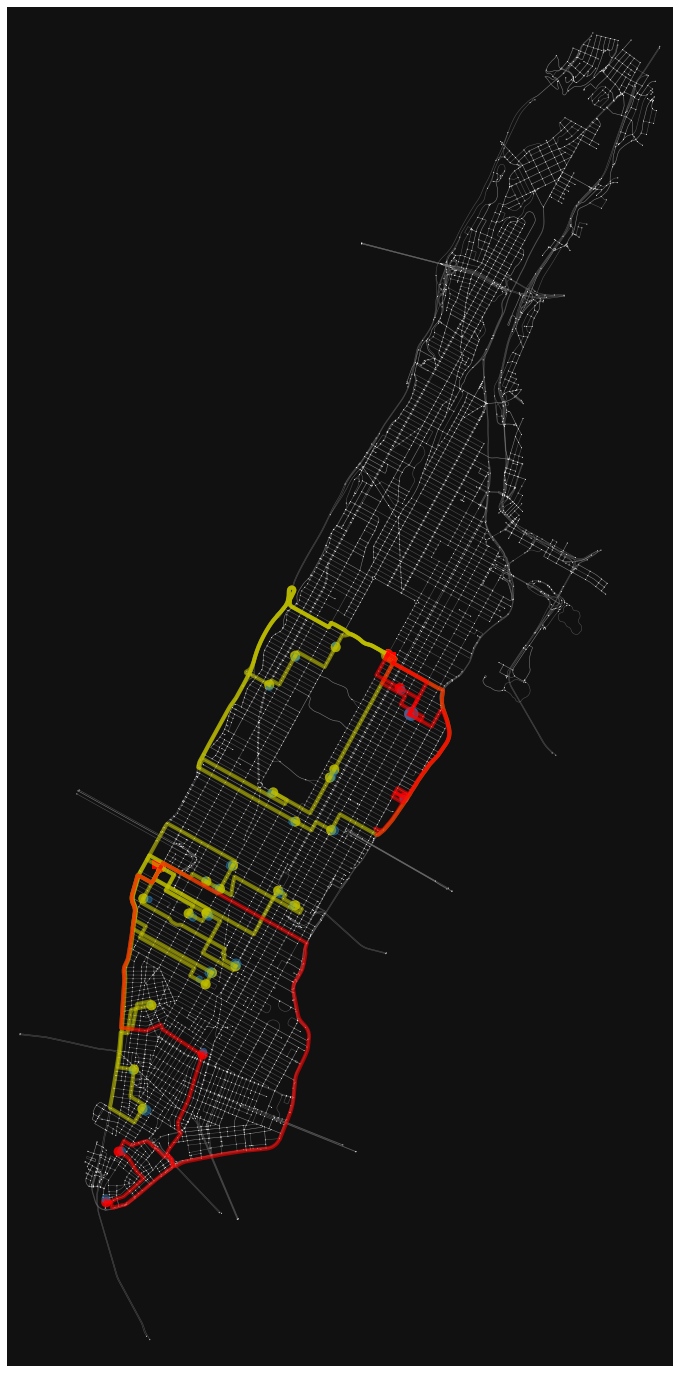

In [234]:
myg, fig, ax = mapDataOSM(data,dep_locs,snap_to_grid=False,route_data=mypaths, route_colors=mycolors, from_place = 'Manhattan',buffer_m=500)